In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
from matplotlib import colors, ticker, cm, gridspec
import numpy as np
import pandas
from scipy.interpolate import interp1d
from orbit_class import Orbit
from misc_utils import *   
import ifs_noise_model as snr_ifs
import imaging_noise_model as snr_im
import juneper_model as hpm  
import coolTLUSTY_model as cpm
import simulate_data as simdata
import nice_plotting_forms as pf
from astropy.io import fits

/Users/blacy/EGPSemesterProject/direct-imaging-sims/WFIRST_SIM/misc_utils.py:159: RuntimeWarning: divide by zero encountered in true_divide
  tau_PSF = interp1d(rlamD,coreThruput/occTrans,fill_value=0.0,bounds_error=False)


In [3]:
fulltab = pandas.read_csv("imaged_wfirst_cgi_options.csv")
fulltab.columns
names = fulltab['# name']
masses = fulltab['mass']
radii = fulltab['radius']
sma = fulltab['semi_major_axis']
vmag = fulltab['mag_v']
startype =fulltab['star_sp_type']
ecc = fulltab['eccentricity']
inc = fulltab['inclination']
ome = fulltab['omega']
tp = fulltab['tperi']
dist = fulltab['star_distance']
disc = fulltab['star_detected_disc']
smass = fulltab['star_mass']

orbit_list = []
star_mask = []
for k in range(len(names)):
    stellar_mass = smass[k]  # stellar mass in units of solar mass 
    a = sma[k]               # semimajor axis (in au)
    e = ecc[k]               # eccentricity
    i = inc[k]               # inclination (degrees)
    om = ome[k]              # longitude of ascending node (degrees)
    t = 0.0                  #2530054 % (7.37*365) # epoch of perihelion passage (julian date) 2530054
    r = radii[k] 
    d = dist[k]
    argperi = 3.13     # argument of perihelion (degrees)   
    
    # fill in defaults for the NaN values 
    if np.isnan(e):
        e = 0.0001
    if np.isnan(om):
        om = 89.0
    if np.isnan(r):
        r = 0.99
    if np.isnan(stellar_mass) or np.isnan(a) or np.isnan(d) or np.isnan(i):
        #print(k,names[k],' missing key measurements (stellar mass, semi major axis, or inclination)')
        pass
    else:
        star_mask.append(k)
    orbit_pars = np.array([e,i,om,t,a,argperi,stellar_mass,r,d])
    orbit = Orbit(orbit_pars) 
    orbit_list.append(orbit)

In [4]:
rvplanets = pandas.read_csv("known_RV_wfirst_cgi_options.csv")
rvplanets.columns
rvnames = rvplanets['# name']
rvmasses = rvplanets['mass']
rvradii = rvplanets['radius']
rvsma = rvplanets['semi_major_axis']
rvvmag = rvplanets['mag_v']
rvstartype =rvplanets['star_sp_type']
rvecc = rvplanets['eccentricity']
rvinc = rvplanets['inclination']
rvome = rvplanets['omega']
rvtp = rvplanets['tperi']
rvdist = rvplanets['star_distance']
rvdisc = rvplanets['star_detected_disc']
rvsmass = rvplanets['star_mass']

rvorbit_list = []
rvstar_mask = []
for k in range(len(rvnames)):
    stellar_mass = rvsmass[k]  # stellar mass in units of solar mass 
    a = rvsma[k]               # semimajor axis (in au)
    e = rvecc[k]               # eccentricity
    i = rvinc[k]               # inclination (degrees)
    om = rvome[k]              # longitude of ascending node (degrees)
    t = 0.0                  #2530054 % (7.37*365) # epoch of perihelion passage (julian date) 2530054
    r = rvradii[k] 
    d = rvdist[k]
    argperi = 3.13     # argument of perihelion (degrees)   
    
    # fill in defaults for the NaN values 
    if np.isnan(e):
        e = 0.0001
    if np.isnan(om):
        om = 89.0
    if np.isnan(r):
        r = 0.99
    if np.isnan(stellar_mass) or np.isnan(a) or np.isnan(d) or np.isnan(i):
        pass
        #print(k,rvnames[k],' missing key measurements (stellar mass, semi major axis, or inclination)')
    else:
        rvstar_mask.append(k)
    orbit_pars = np.array([e,i,om,t,a,argperi,stellar_mass,r,d])
    orbit = Orbit(orbit_pars) 
    rvorbit_list.append(orbit)        

In [5]:
'''
Disk -- 0.5 microns 0.16 -0.515 ,  1.0 microns 0.33 - 1.03 arcsec
Bowtie/HLC  -- 0.5 microns 0.077 - 0.232, 1 micron 0.15-0.46 arcsec
'''
IWA_ifs_short_wl = 0.33
OWA_ifs_short_wl = 0.515

IWA_ifs_long_wl = 0.15
OWA_ifs_long_wl = 0.232

In [6]:
Rp = rjup
contrast = 10**-9
optimistic_alim = np.sqrt(Rp**2/contrast * 1.0 * 0.5)/au_to_m
pessimistic_alim = np.sqrt(Rp**2/contrast * 0.25 * 0.33)/au_to_m

D = np.linspace(1.0,500.0,500)
aiwa = D*IWA_ifs_long_wl
aowa = D*OWA_ifs_long_wl
aiwa2 = D*IWA_ifs_short_wl
aowa2 = D*OWA_ifs_short_wl

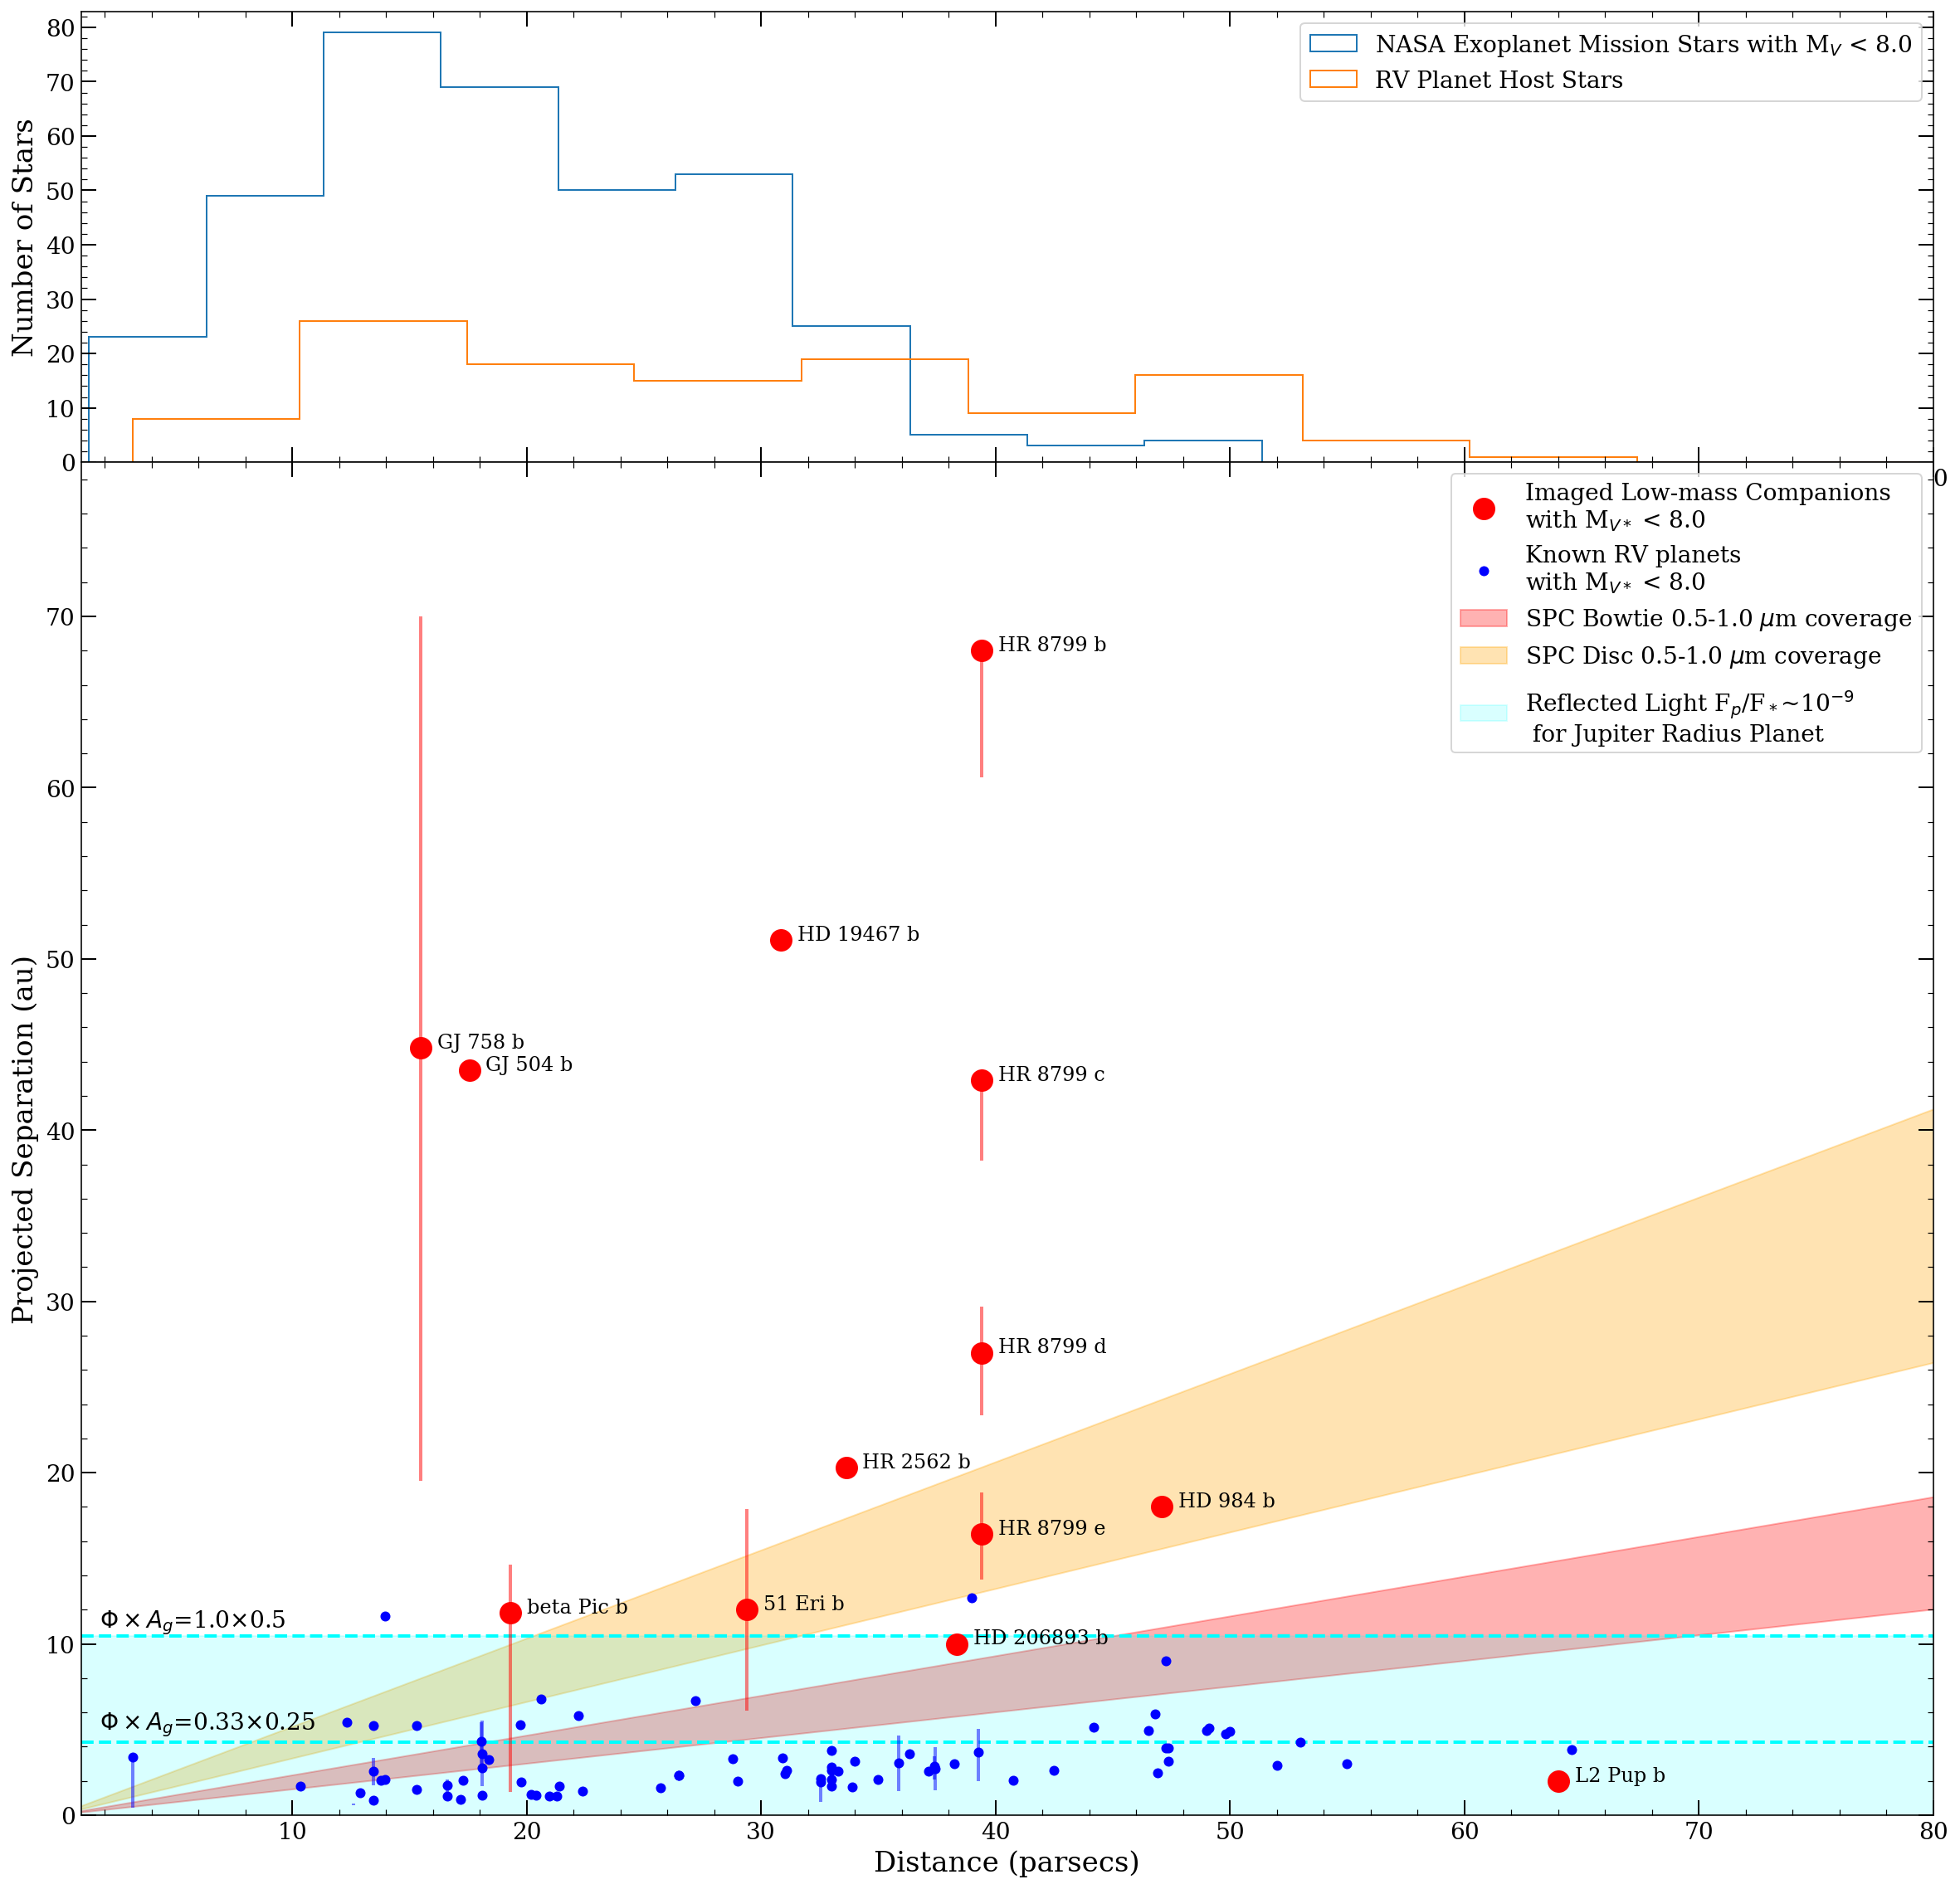

In [13]:
AUMAX = 79.0
DMAX = 80.0
fig,axes = plt.subplots(nrows=2, ncols=1, sharex='col',figsize=(20,20))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,3]) 
starfile = 'missionstars_2019.05.06_10.28.09.csv'
startable = pandas.read_csv(starfile)
star_dist = startable['st_dist']
fig.subplots_adjust(hspace=0)
ax0 = plt.subplot(gs[0])
plt.hist(star_dist,histtype='step',label='NASA Exoplanet Mission Stars with M$_V$ < 8.0')
plt.hist(rvdist,histtype='step',bins=14,label='RV Planet Host Stars')
#plt.hist(dist,histtype='step',bins=20,label='Imaged companion systems')
plt.ylabel('Number of Stars',fontsize=17)
plt.legend(fontsize=14)
ax0.set_xlim(1,DMAX)
ax1 = plt.subplot(gs[1])
plt.fill_between(D,aiwa,aowa,alpha=0.3,color='red',label='SPC Bowtie 0.5-1.0 $\mu$m coverage')
plt.fill_between(D,aiwa2,aowa2,alpha=0.3,color='orange',label='SPC Disc 0.5-1.0 $\mu$m coverage')
plt.fill_between(D,np.zeros(len(D)),np.zeros(len(D))+optimistic_alim,alpha=0.15,color='cyan',label='Reflected Light F$_p$/F$_*$~10$^{-9}$\n for Jupiter Radius Planet')
plt.hlines([pessimistic_alim,optimistic_alim],np.min(D),np.max(D),linestyle='--',color='cyan')

# the directly imaged things
brightmask = np.where(vmag<8.0)[0]
sizemask = np.where(masses>0.5)[0]
mask = np.intersect1d(brightmask,sizemask)
plt.plot(dist[mask],sma[mask],'r.',markersize=25,label='Imaged Low-mass Companions\nwith M$_{V*}$ < 8.0')
for k in range(len(dist)):
    if sma[k] < AUMAX and dist[k]<DMAX and vmag[k] < 8.0 :
        plt.text(dist[k]+0.7,sma[k],names[k],fontsize=12)
    if k in star_mask:
        orbit = orbit_list[k]
        minsep,maxsep=sma[k],sma[k]
        for ophase in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]:
            proj_sep = orbit.ophase_to_wa(ophase)*orbit.dist*pc_to_m/au_to_m
            if minsep > proj_sep:
                minsep = proj_sep
            if maxsep < proj_sep:
                maxsep = proj_sep
        if vmag[k]<8.0 and sma[k] < AUMAX and dist[k]<DMAX :
            plt.vlines(dist[k],minsep,maxsep,color='r',alpha=0.5)


# the known RV planets
brightmask = np.where(rvvmag<8.0)[0]
sizemask = np.where(rvmasses>0.6)[0]
mask = np.intersect1d(brightmask,sizemask)
plt.plot(rvdist[mask],rvsma[mask],'b.',markersize=10,label='Known RV planets\nwith M$_{V*}$ < 8.0')
for k in range(len(rvdist)):
#     if rvsma[k] < AUMAX and rvdist[k]<DMAX and rvvmag[k] < 5.5 and rvmasses[k]>0.8:
#         plt.text(rvdist[k],rvsma[k],rvnames[k],fontsize=10)
    if k in rvstar_mask:
        orbit = rvorbit_list[k]
        minsep,maxsep=rvsma[k],rvsma[k]
        for ophase in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]:
            proj_sep = orbit.ophase_to_wa(ophase)*orbit.dist*pc_to_m/au_to_m
            if minsep > proj_sep:
                minsep = proj_sep
            if maxsep < proj_sep:
                maxsep = proj_sep
        if rvvmag[k]<8.0:
            plt.vlines(rvdist[k],minsep,maxsep,color='b',alpha=0.5)

            
# ADD BD companions to MS stars here!            
            
plt.ylabel('Projected Separation (au)',fontsize=17)
plt.xlabel('Distance (parsecs)',fontsize=17)
ax1.set_xlim(1,DMAX)
ax1.set_ylim(0,AUMAX)
plt.text(1.8,11,'$\Phi\\times A_{g}$=1.0$\\times$0.5',color='k',fontsize=14)
plt.text(1.8,5.0,'$\Phi\\times A_{g}$=0.33$\\times$0.25',color='k',fontsize=14)
        
legend = ax1.legend(loc='upper right',frameon=True,fontsize=14)
legend.get_frame().set_facecolor('white')
plt.savefig('Potential_Targets.png')

In [16]:
# known orbital elements and v mag < 8.0 
# 51 Eri b
# HR 8799 e
# beta Pic b
# no orbital elements, but reasonable loc + v mag < 8.0
# HD 206893 b
# HD 984 b
# HR 2562 b
# --------------
# close enough that should be more carefully modelled
# HR 8799 d
# L2 Pup b
# GJ 758 b
# GJ 504 b
# HD 19467 b
for k in range(len(dist)):
    if sma[k] < AUMAX and dist[k]<DMAX and vmag[k] < 8.0 :
        print(k,names[k],startype[k])
print(fulltab.columns)        

22 51 Eri b F0IV
37 GJ 504 b GOV
39 GJ 758 b K0V
49 HD 19467 b G3V
51 HD 206893 b F5V
56 HD 984 b F7V
67 HR 2562 b F5V
70 HR 8799 b A5V
71 HR 8799 c A5V
72 HR 8799 d A5V
73 HR 8799 e A5V
75 L2 Pup b M5
121 beta Pic b A6V
Index(['# name', 'planet_status', 'mass', 'mass_error_min', 'mass_error_max',
       'mass_sini', 'mass_sini_error_min', 'mass_sini_error_max', 'radius',
       'radius_error_min', 'radius_error_max', 'orbital_period',
       'orbital_period_error_min', 'orbital_period_error_max',
       'semi_major_axis', 'semi_major_axis_error_min',
       'semi_major_axis_error_max', 'eccentricity', 'eccentricity_error_min',
       'eccentricity_error_max', 'inclination', 'inclination_error_min',
       'inclination_error_max', 'angular_distance', 'discovered', 'updated',
       'omega', 'omega_error_min', 'omega_error_max', 'tperi',
       'tperi_error_min', 'tperi_error_max', 'tconj', 'tconj_error_min',
       'tconj_error_max', 'tzero_tr', 'tzero_tr_error_min',
       'tzero_tr_e

In [28]:
mtable = [22,121,51,56,67,72,73]#,37,39,49,70,71,75]
ofile = open('best.txt','w')
labels = '# name, mass, radius, orbital_period, semi_major_axis, eccentricity, \
            inclination, omega, tperi, temp_calculated, temp_measured, \
            log_g, mag_v, star_distance, star_metallicity, \
            star_mass, star_radius, star_sp_type, star_age, star_teff, \
            star_detected_disc'
ofile.write(labels+'\n')
table_keys = ['# name','mass','radius','orbital_period','semi_major_axis','eccentricity', 
              'inclination','omega','tperi',
              
              'temp_calculated','temp_measured', 'log_g',  
              'mag_v','star_distance','star_metallicity','star_mass', 'star_radius', 
              
              'star_sp_type','star_age',  'star_teff','star_detected_disc'] #24
for k in mtable:
    row = [fulltab[key][k] for key in table_keys]
    row = tuple(row)
    s1 = '%s   & %.5f & %.5f & %.5f & %.5f & %.5f & %.5f & %.5f & %.5f &' % row[0:9]
    s2 = '%.5f & %.5f & %.5f & %.5f & %.5f & %.5f & %.5f & %.5f &' % row[9:17]
    s3 = '%s   & %.5f & %.5f & %s\n' % row[17:21]
    ofile.write(s1+s2+s3)
ofile.close()

ofile = open('best.csv','w')
ofile.write(labels+'\n')
for k in mtable:
    row = [fulltab[key][k] for key in table_keys]
    row = tuple(row)
    s1 = '%s   , %.3f , %.3f , %.3f , %.3f , %.3f , %.3f , %.3f , %.3f ,' % row[0:9]
    s2 = '%.3f , %.3f , %.3f , %.3f , %.3f , %.3f , %.3f , %.3f ,' % row[9:17]
    s3 = '%s   , %.3f , %.3f , %s\n' % row[17:21]
    ofile.write(s1+s2+s3)
ofile.close()

In [4]:
'''
22 51 Eri b F0IV*
37 GJ 504 b GOV -
39 GJ 758 b K0V - 
49 HD 19467 b G3V -
51 HD 206893 b F5V ~
56 HD 984 b F7V  ~
67 HR 2562 b F5V ~
70 HR 8799 b A5V -
71 HR 8799 c A5V -
72 HR 8799 d A5V ~
73 HR 8799 e A5V ~
75 L2 Pup b M5 -
121 beta Pic b A6V*
'''
startypekey = {22:'f5v',37:'g0v',39:'k0v',49:'g5v',51:'f5v',56:'f5v',67:'f5v',
              70:'a5v',71:'a5v',72:'a5v',73:'a5v',75:'m5v',121:'a5v'}
goodphasekey = {22:0.85,37:0.86,39:0.75,49:0.75,51:0.55,56:0.63,67:0.65,
               70:0.75,71:0.75,72:0.15,73:0.85,75:0.75,121:0.9}
planet_dictionaries = []
for k in [22,37,39,49,51,56,67,70,71,72,73,75,121]:
    pdict = {}
    pdict['pname'] = names[k]
    pdict.update({'d_obs':dist[k]})
    M = vmag[k] - 5.0*np.log10(pdict['d_obs']/10.0)
    pdict.update({'Mstar':M})     # absolute stellar V-band magnitude 
    pdict.update({'Nez':1.0})     # exozodi level
    stellartype = startypekey[k]     # stellar type
    stellar_mass = smass[k]       # stellar mass in units of solar mass 
                                  # this is only used in orbit object, not really relevant for SNR calculation
    stellar_spec = 'AuxiliaryData/'+stellartype+'.dat' # imports Hubble 
    ref_wl, ref_flambda = np.loadtxt(stellar_spec, unpack=True, usecols=(0,1))
    fstar_lambda = interp1d(ref_wl,ref_flambda)  # specific flux density W / m^2 / micron, for zero mag star
    pdict.update({'fstar_lambda':fstar_lambda}) # a function which returns 
                                             # specific flux density for any wavelength
    pdict.update({'rp':radii[k]})          # planet radius in Jupiter radii
    pdict.update({'chromo':1.0,'meth':1.0}) 
    pdict.update({'Ag':hpm.juneper_Agfunc(pdict['chromo'],pdict['meth'])}) 
    a = sma[k]            # semimajor axis (in au)
    e = ecc[k]           # eccentricity
    i = inc[k]          # inclination (degrees)
    om = ome[k]         # longitude of ascending node (degrees)
    t = 0.0             #2530054 % (7.37*365) # epoch of perihelion passage (julian date) 2530054
    argperi = 3.13     # argument of perihelion (degrees)    
    r = radii[k]
    
    if np.isnan(e):
        e = 0.0001
    if np.isnan(om):
        om = 89.0
    if np.isnan(r):
        r = 0.99
        pdict.update({'rp':r})
    if np.isnan(i):
        i = 89.0
    
    orbit_pars = np.array([e,i,om,t,a,argperi,
                           stellar_mass,r,pdict['d_obs']])
    orbit = Orbit(orbit_pars) 
    ophase = goodphasekey[k] # orbital phase
    pfunc = avg_empirical # type of phase function to use
    simdata.change_ophase(orbit, pdict, ophase, pfunc) # updates params['sep'], params['phi'], params['wa'] 
    pdict.update(cbe_spc_pars)
    pdict['orbit']=orbit
    planet_dictionaries.append(pdict)

25.60561739505057 0.1437963080477918 2.8409517942317895e-06
25.60561739505057 0.1437963080477918 2.8409517942317895e-06


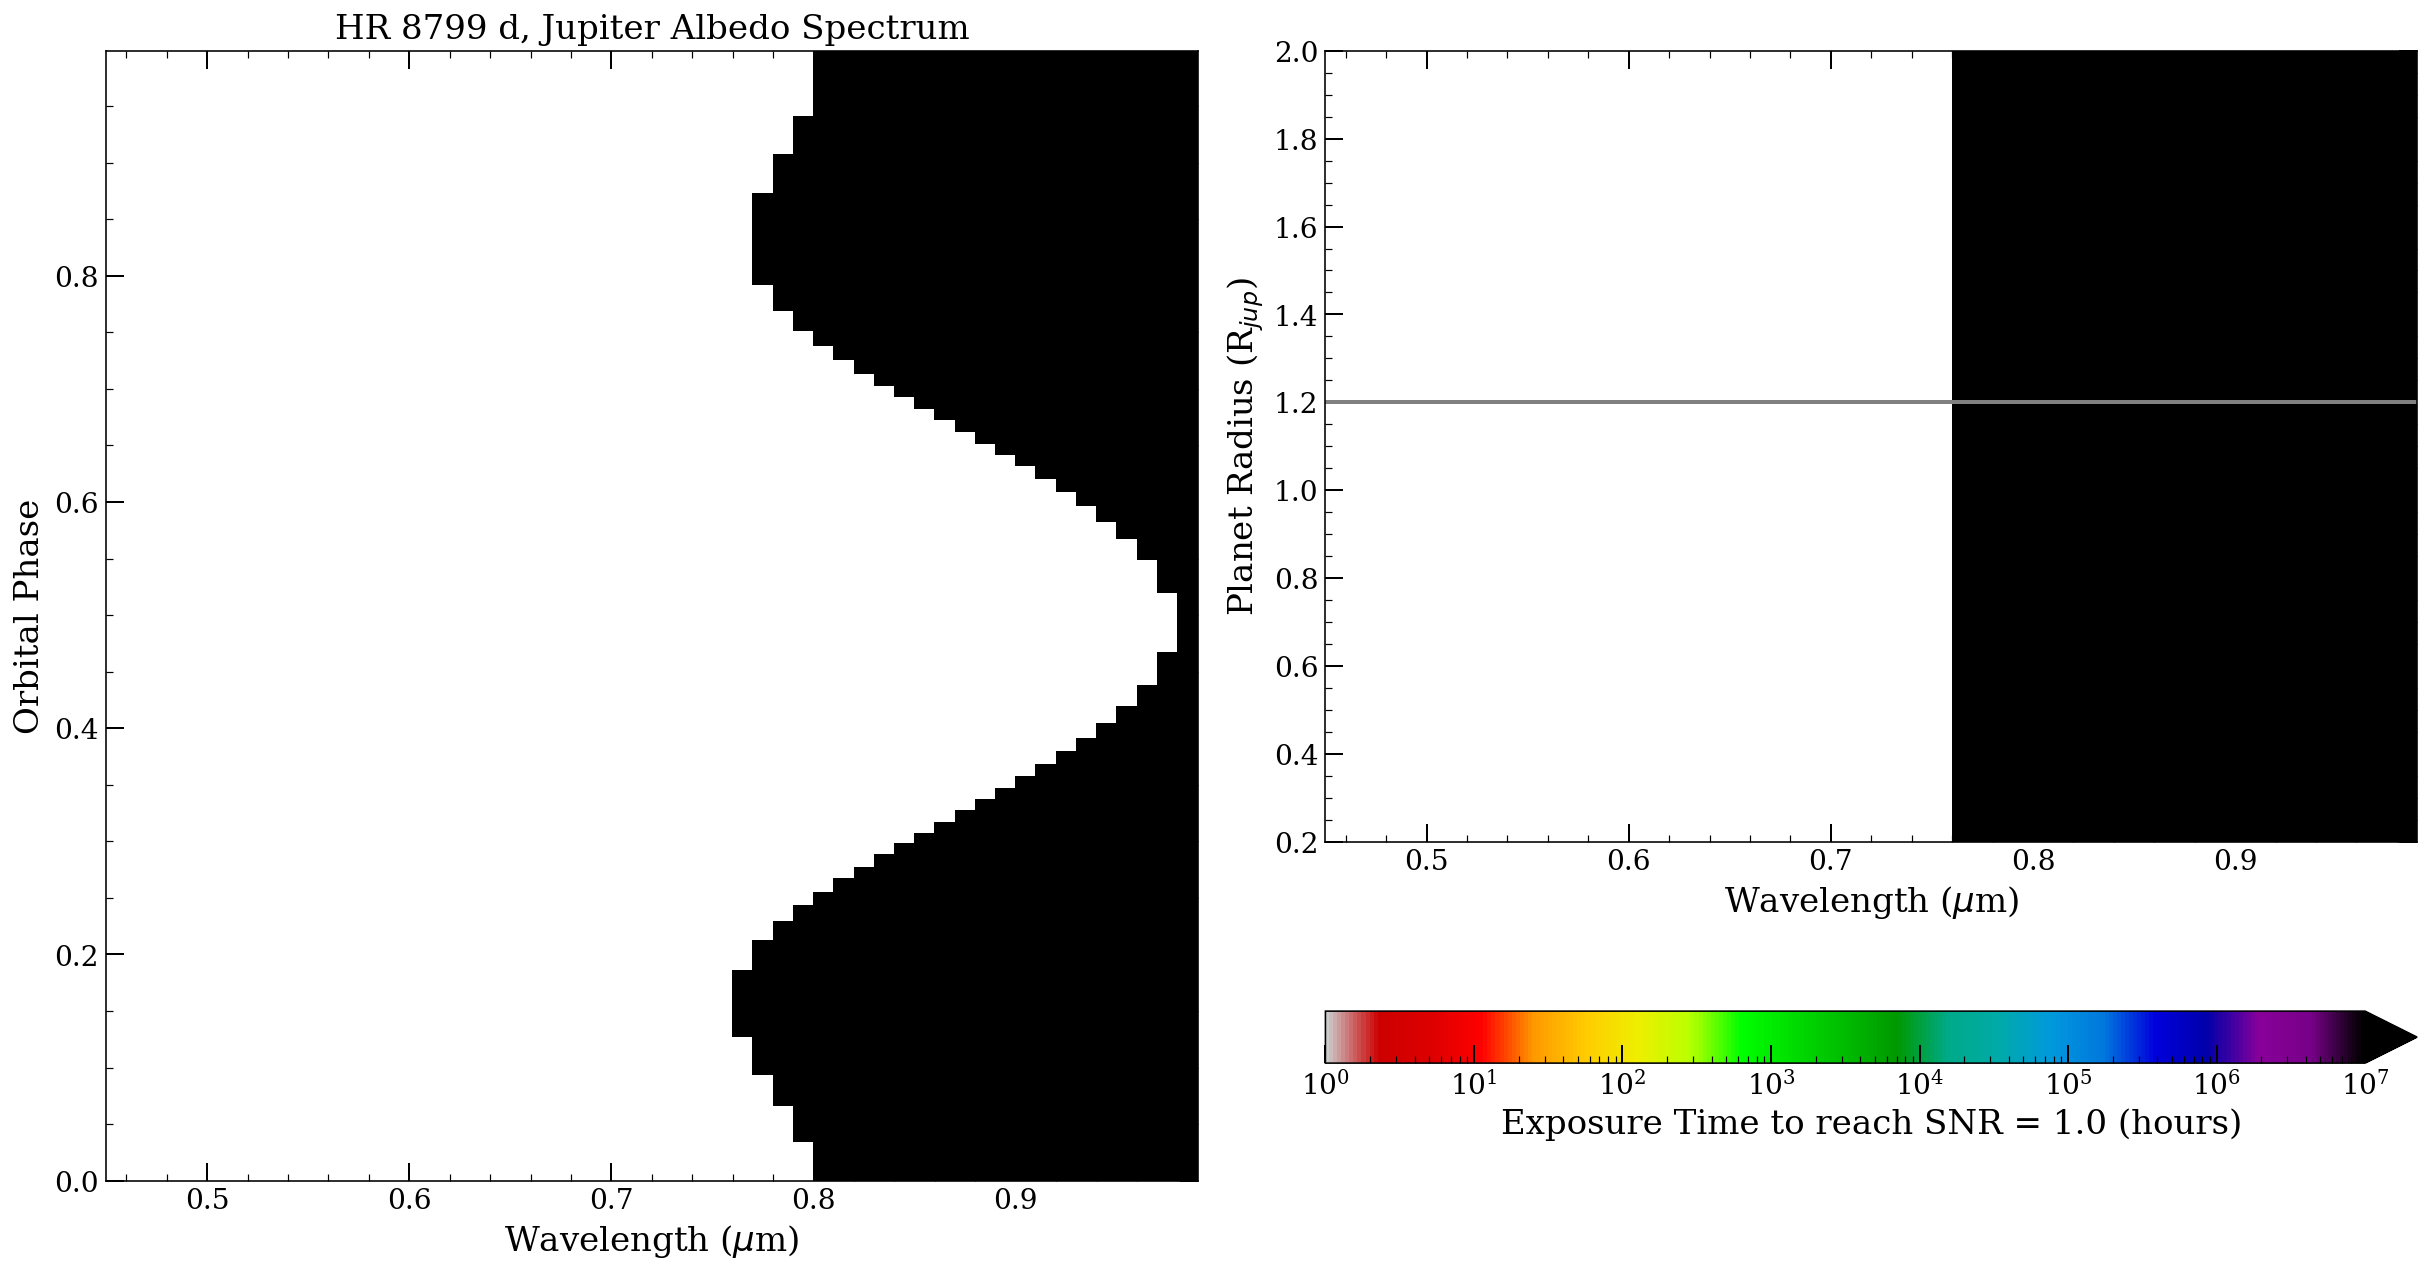

In [7]:
# look at prospects with the IFS
wavelengths = np.arange(0.45,1.0,0.01)
for l in [9]:# range(len(planet_dictionaries)):
    pdict = planet_dictionaries[l]
    print(pdict['sep'], pdict['phi'], pdict['wa'] )
    plt.figure(figsize=(17.0, 9.0))
    ax=plt.subplot(1,2,1)
    pf.ophase_tsnr_plot(pdict,pdict['orbit'],wavelengths,1.0,cbar=False)
    ax.set_title('%s, Jupiter Albedo Spectrum'%pdict['pname'],fontsize=17)
    ax=plt.subplot(1,2,2)
    pf.rp_tsnr_plot(pdict,wavelengths,1.0,cbar=True)
    plt.hlines(pdict['rp'],0.4,1.0,color='grey')
    print(pdict['sep'], pdict['phi'], pdict['wa'] )
    plt.axis([0.45,0.99,0.2,2.0])
    plt.tight_layout()
plt.show()

11.160020427142761 0.5904054836168502 1.3671239371016462e-06
11.160020427142761 0.5904054836168502 1.3671239371016462e-06
43.497227463924716 0.6386045795765614 8.14883012161866e-06
43.497227463924716 0.6386045795765614 8.14883012161866e-06
56.825547009736326 0.4427777002245315 1.6087865003855836e-05
56.825547009736326 0.4427777002245315 1.6087865003855836e-05
51.100000511 0.9778573434751036 4.5859086226935784e-07
51.100000511 0.9778573434751036 4.5859086226935784e-07
10.000951066064081 0.4100262961794472 1.1796590602639173e-06
10.000951066064081 0.4100262961794472 1.1796590602639173e-06
18.001232280431996 0.6630404557420356 1.1932292569339905e-06
18.001232280431996 0.6630404557420356 1.1932292569339905e-06
20.301193336915663 0.7295892475652664 1.5893668257956668e-06
20.301193336915663 0.7295892475652664 1.5893668257956668e-06
68.0 0.46614956896201726 7.391037983682936e-06
68.0 0.46614956896201726 7.391037983682936e-06
42.9 0.46614956896201726 4.662875433797942e-06
42.9 0.46614956896201

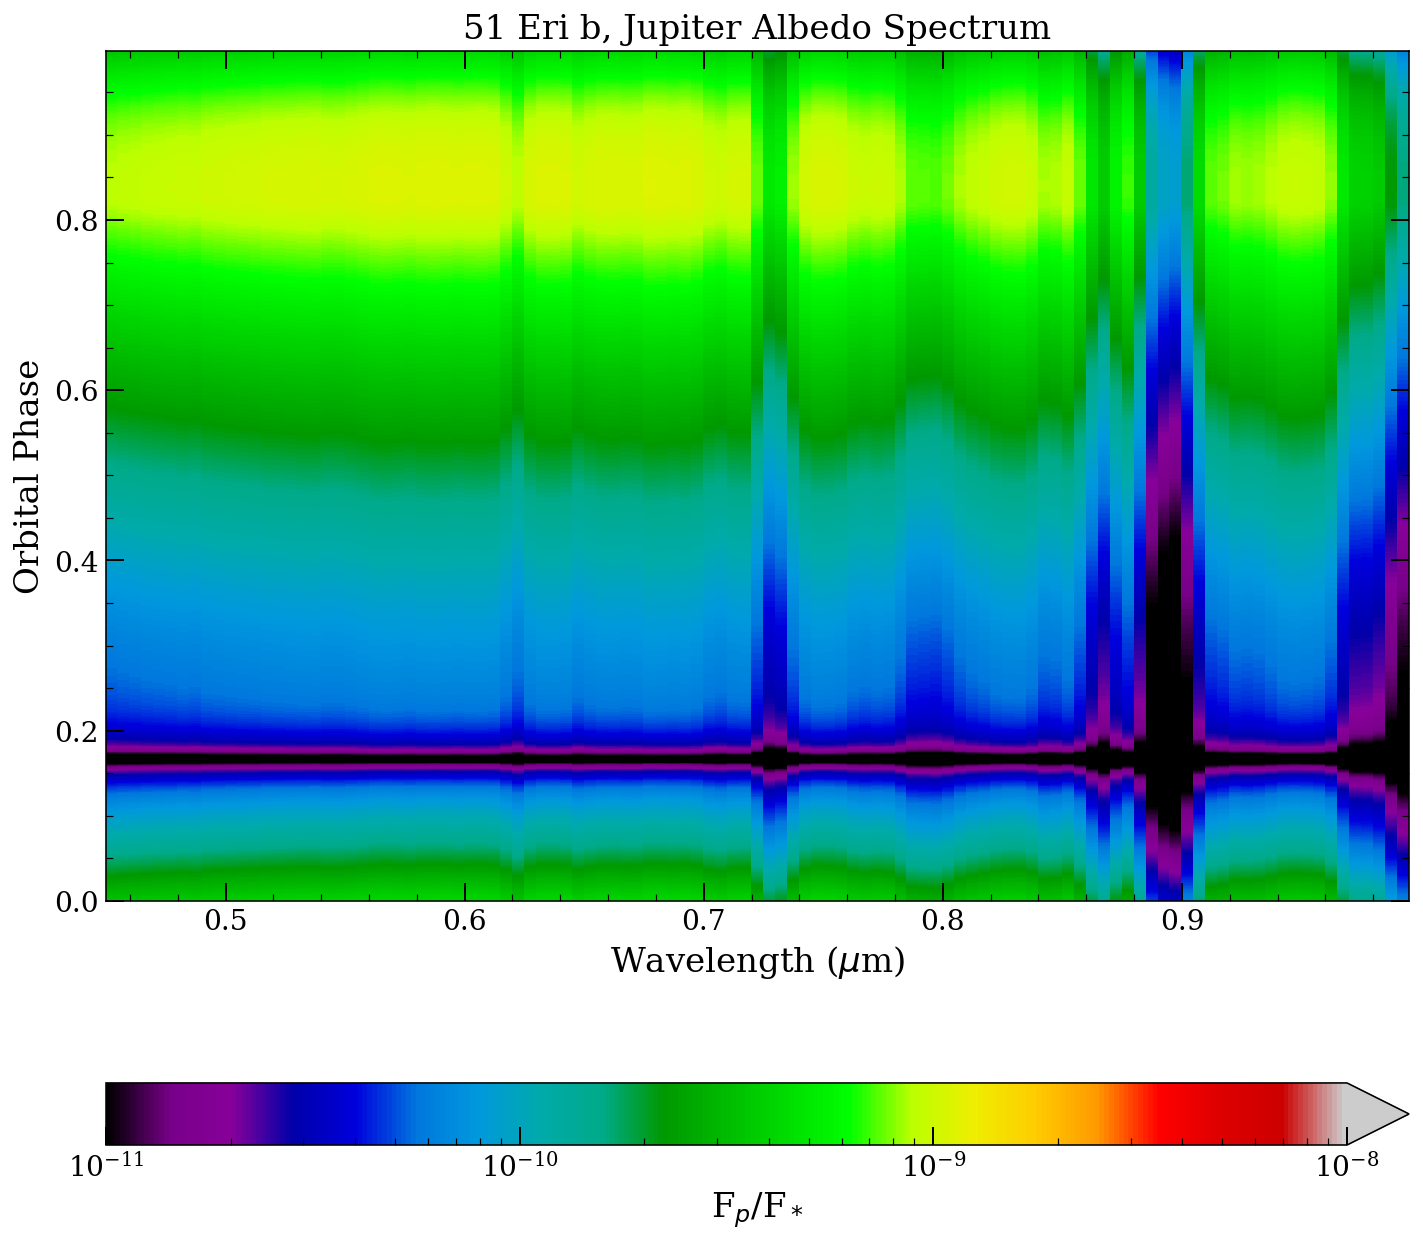

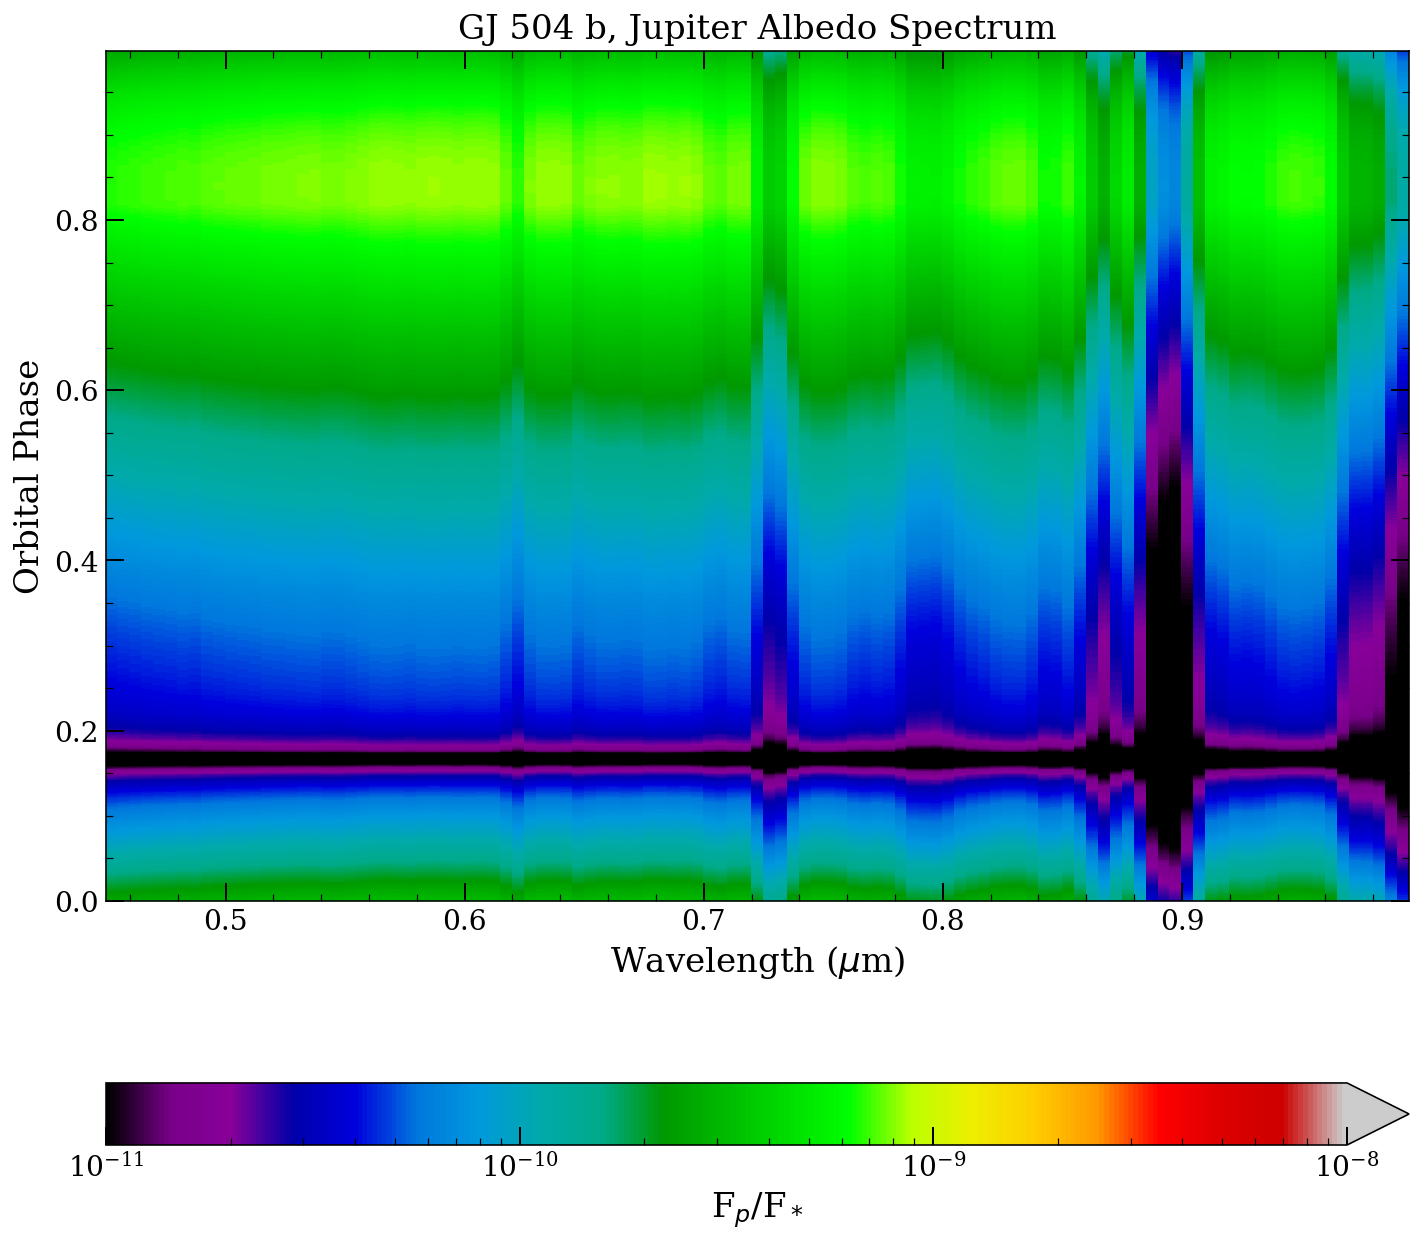

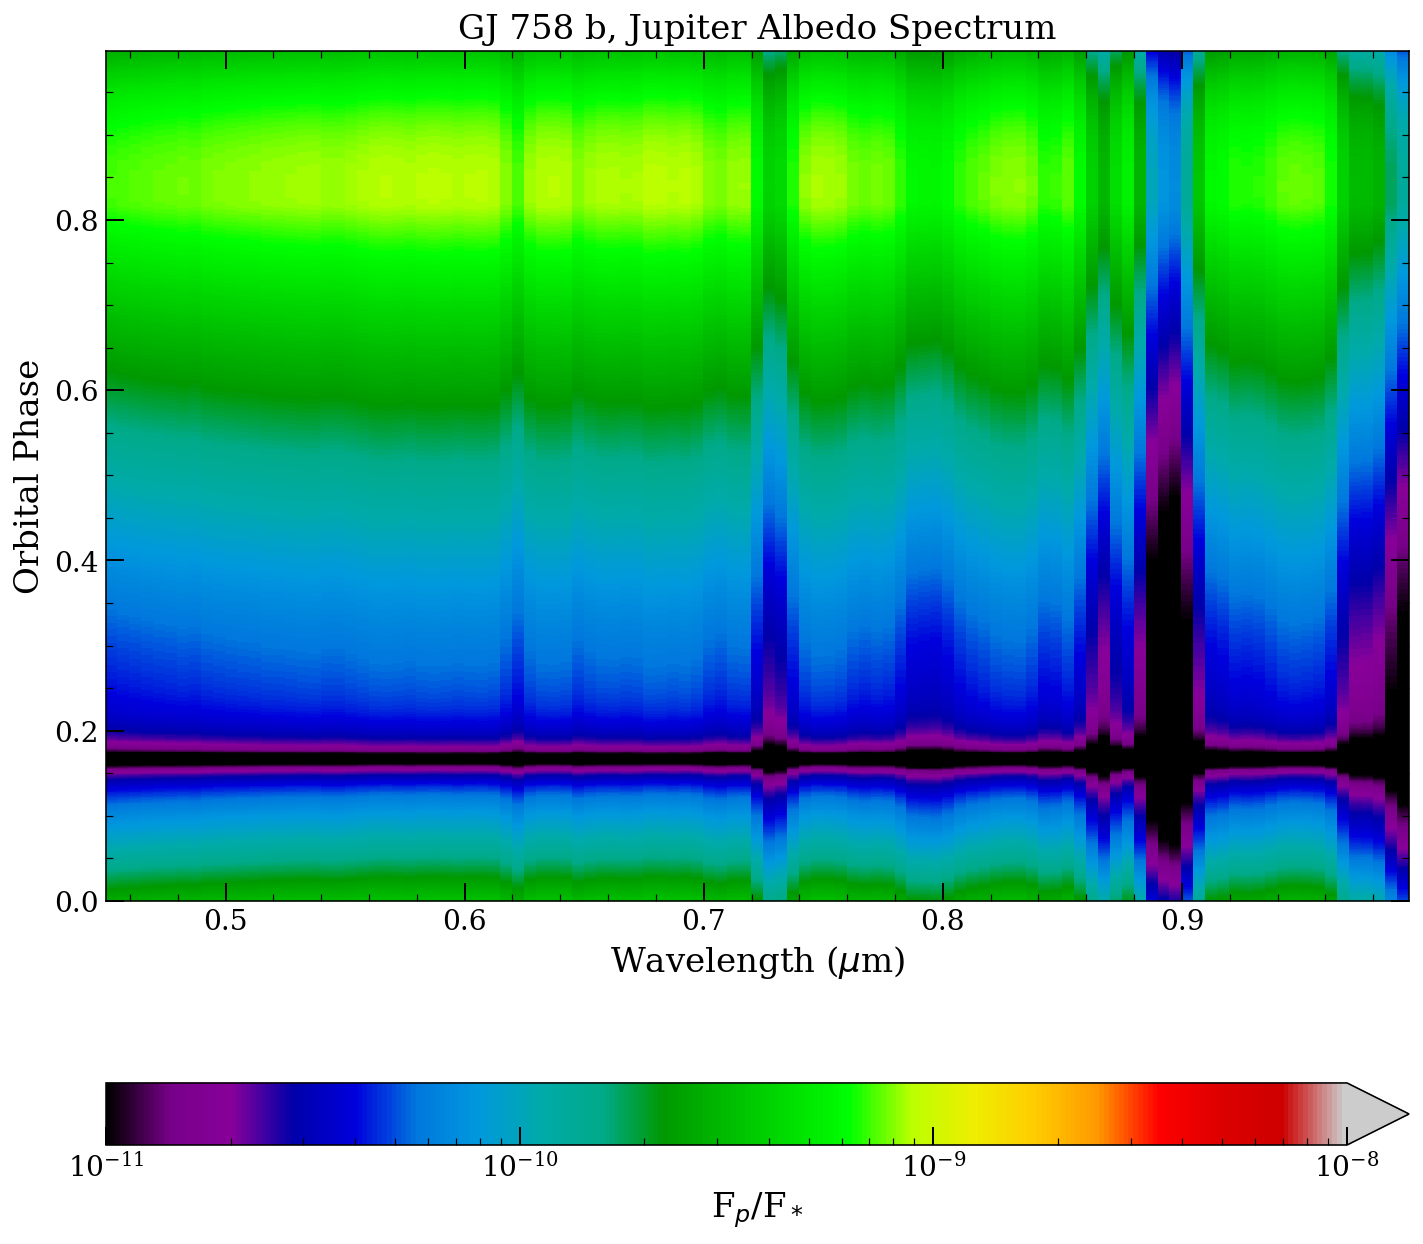

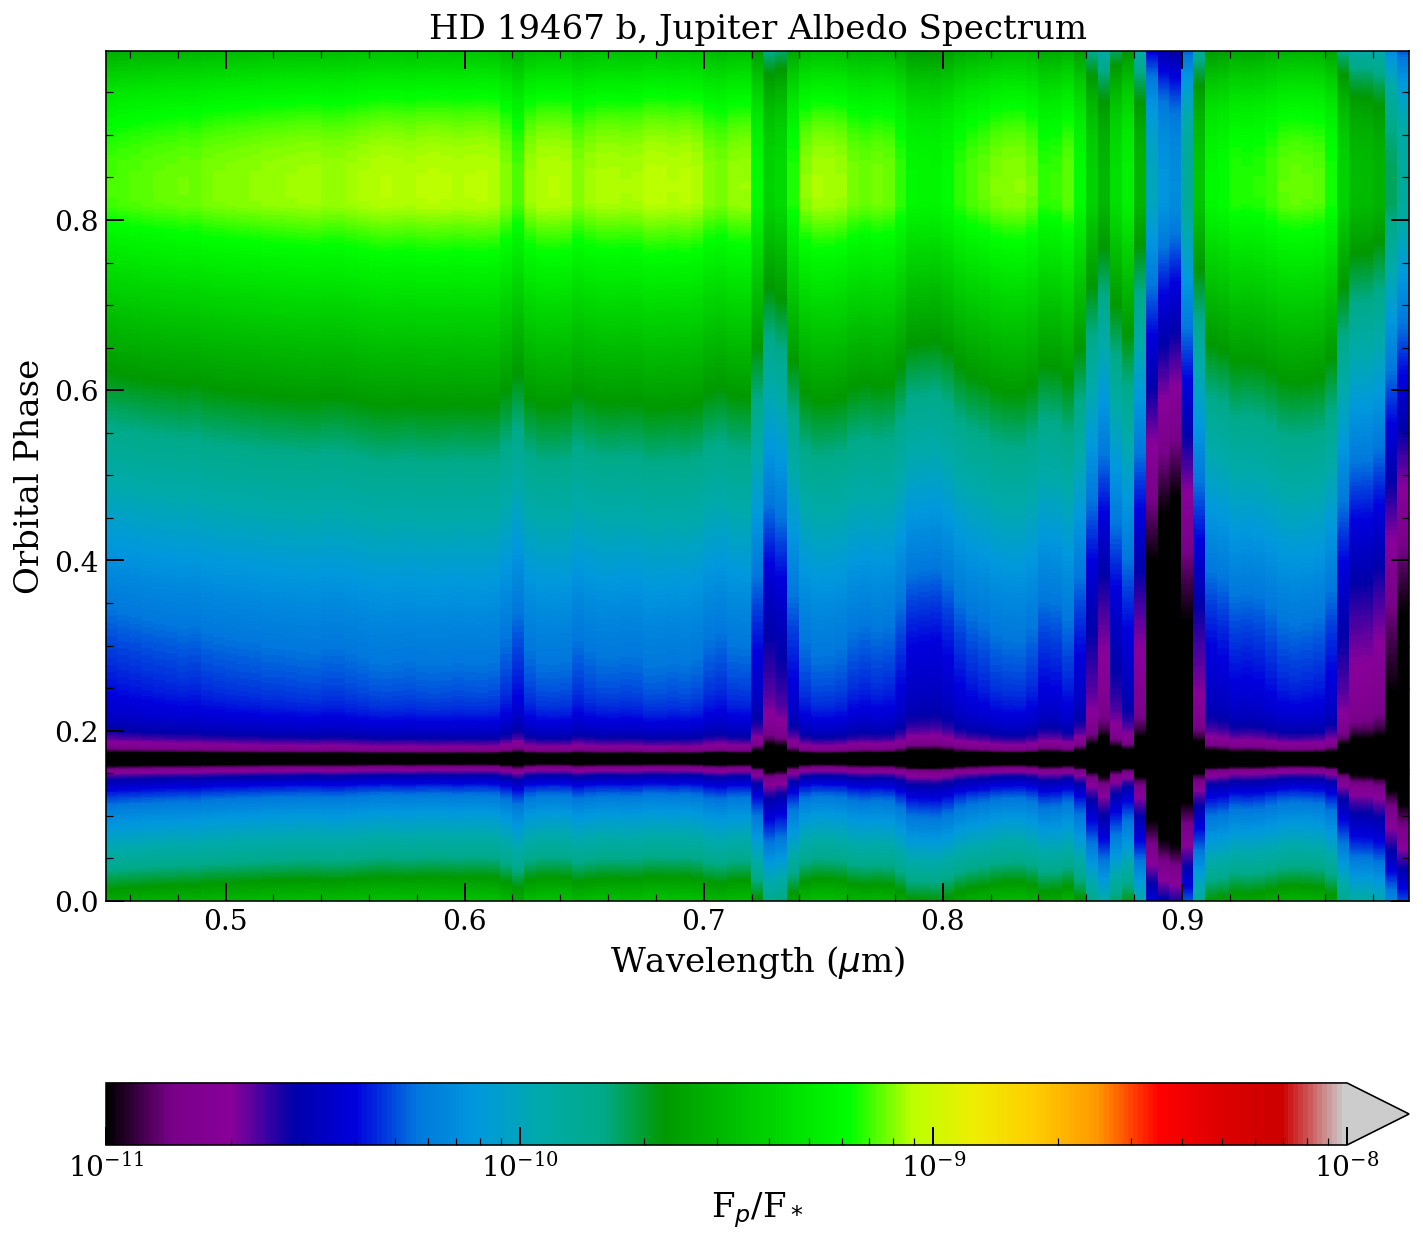

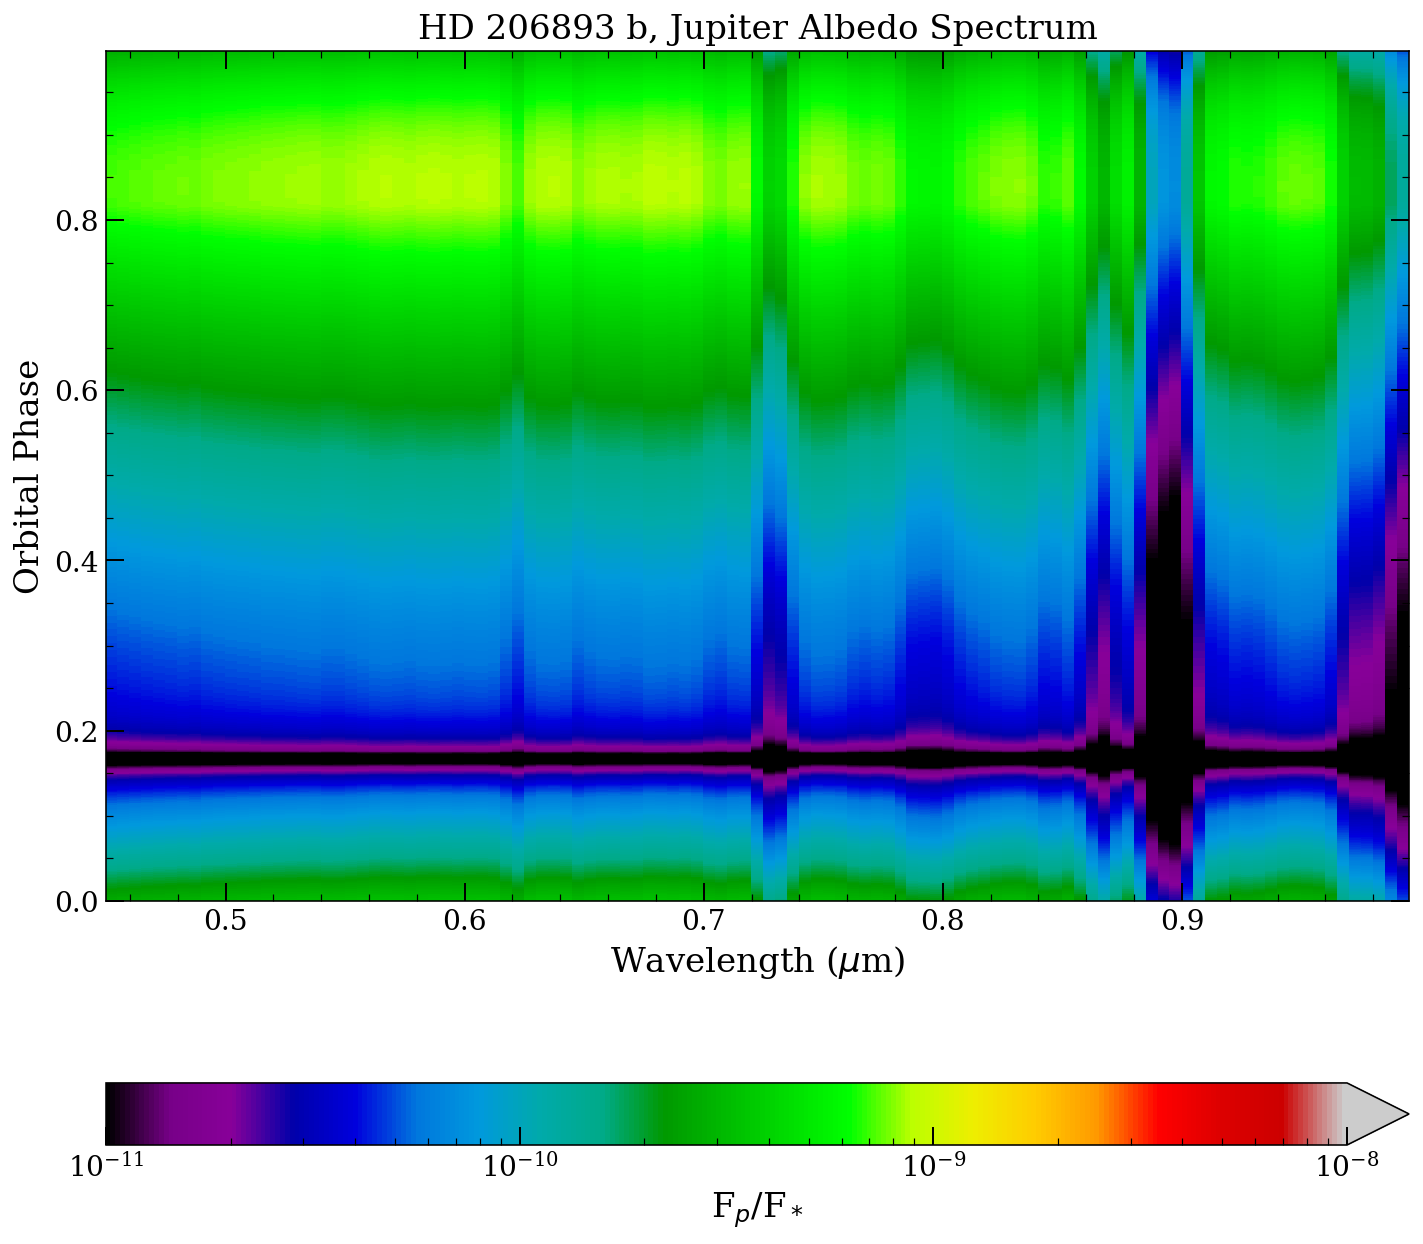

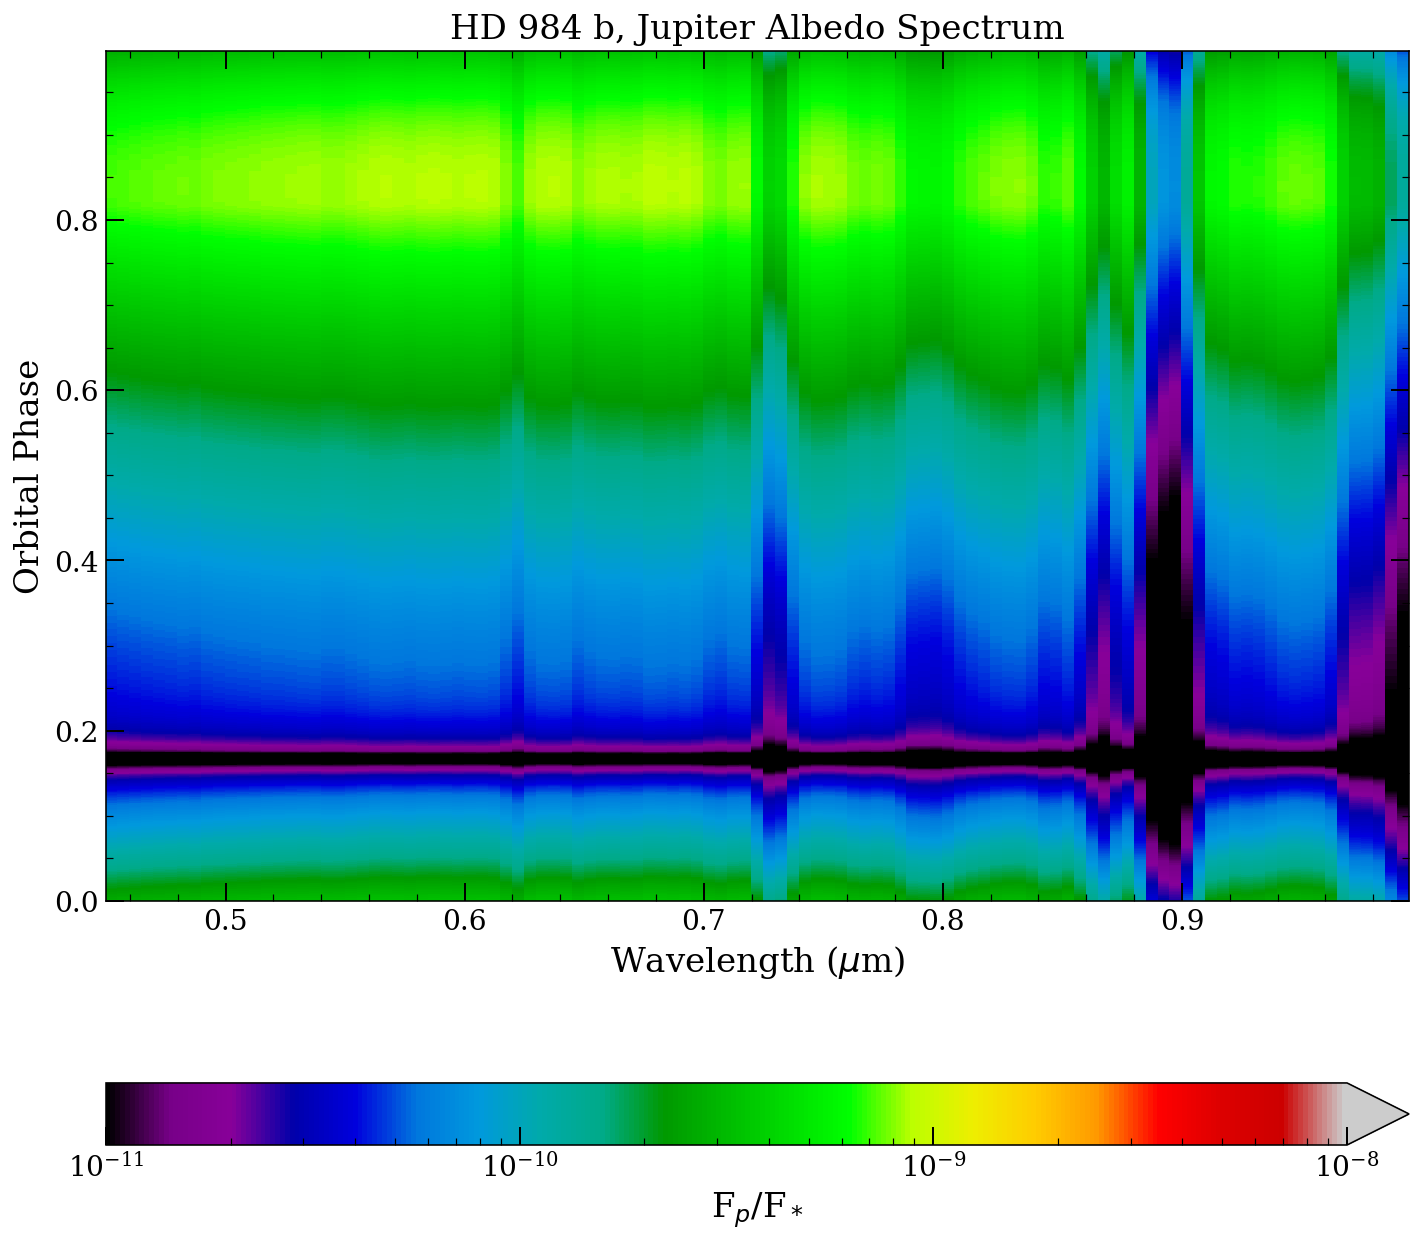

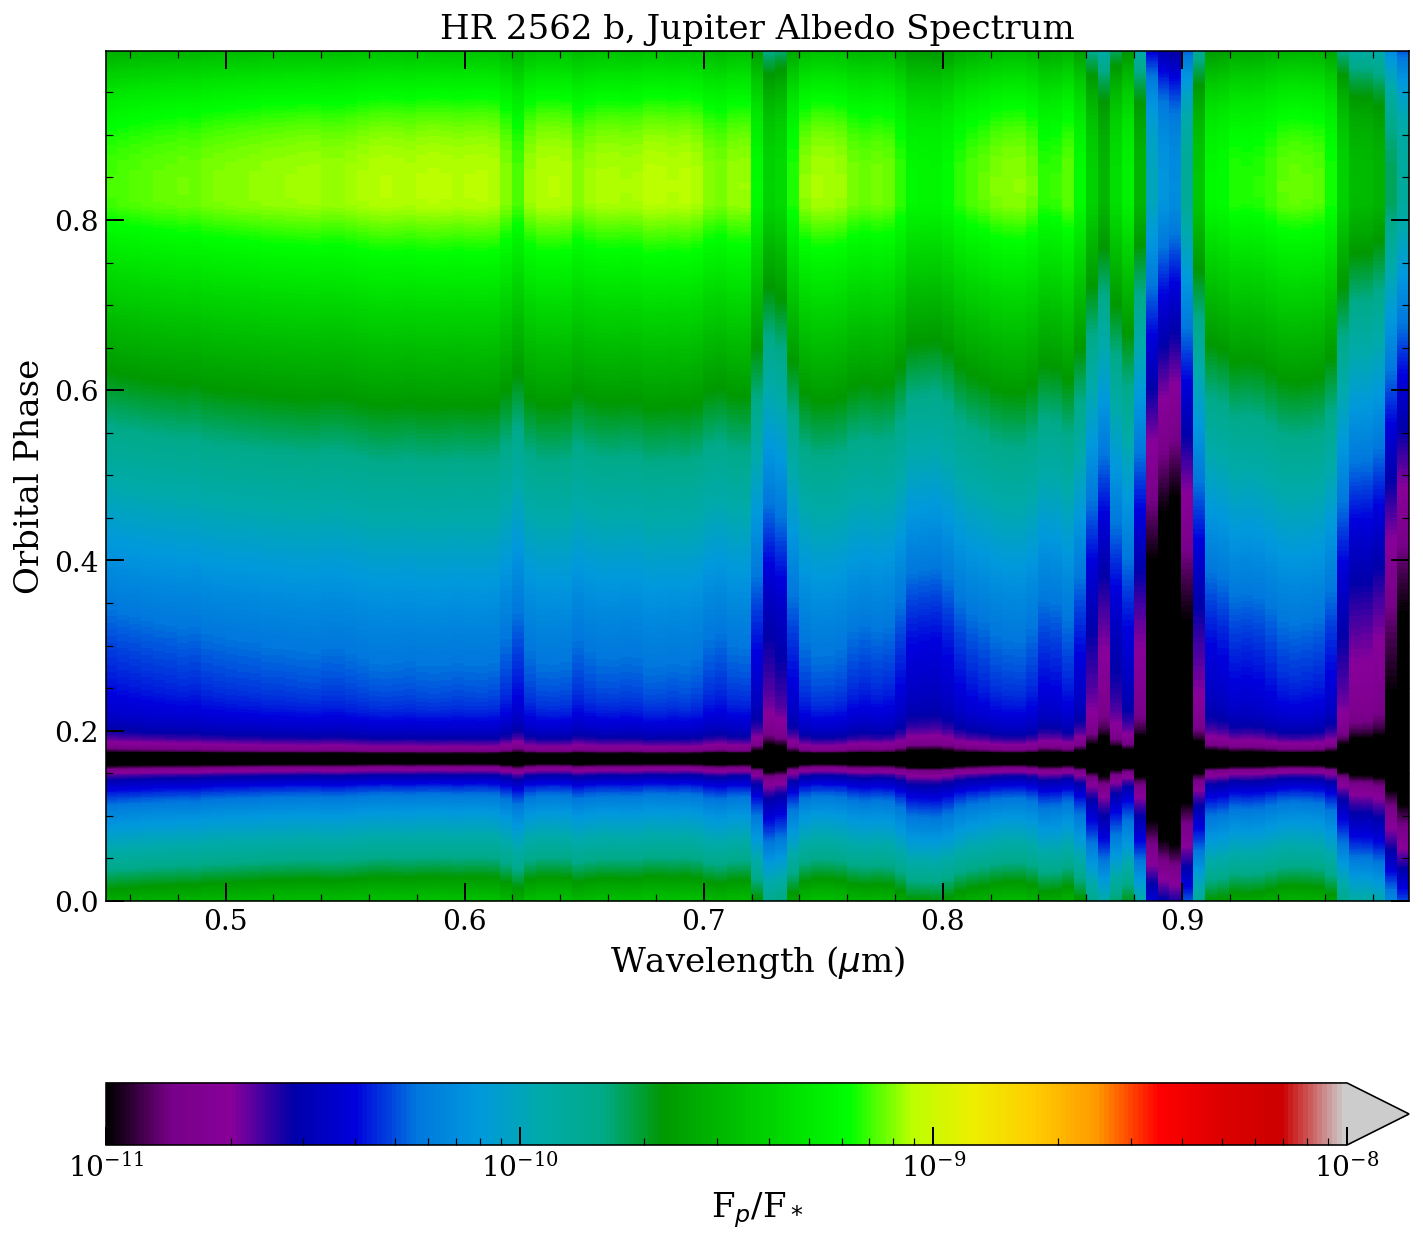

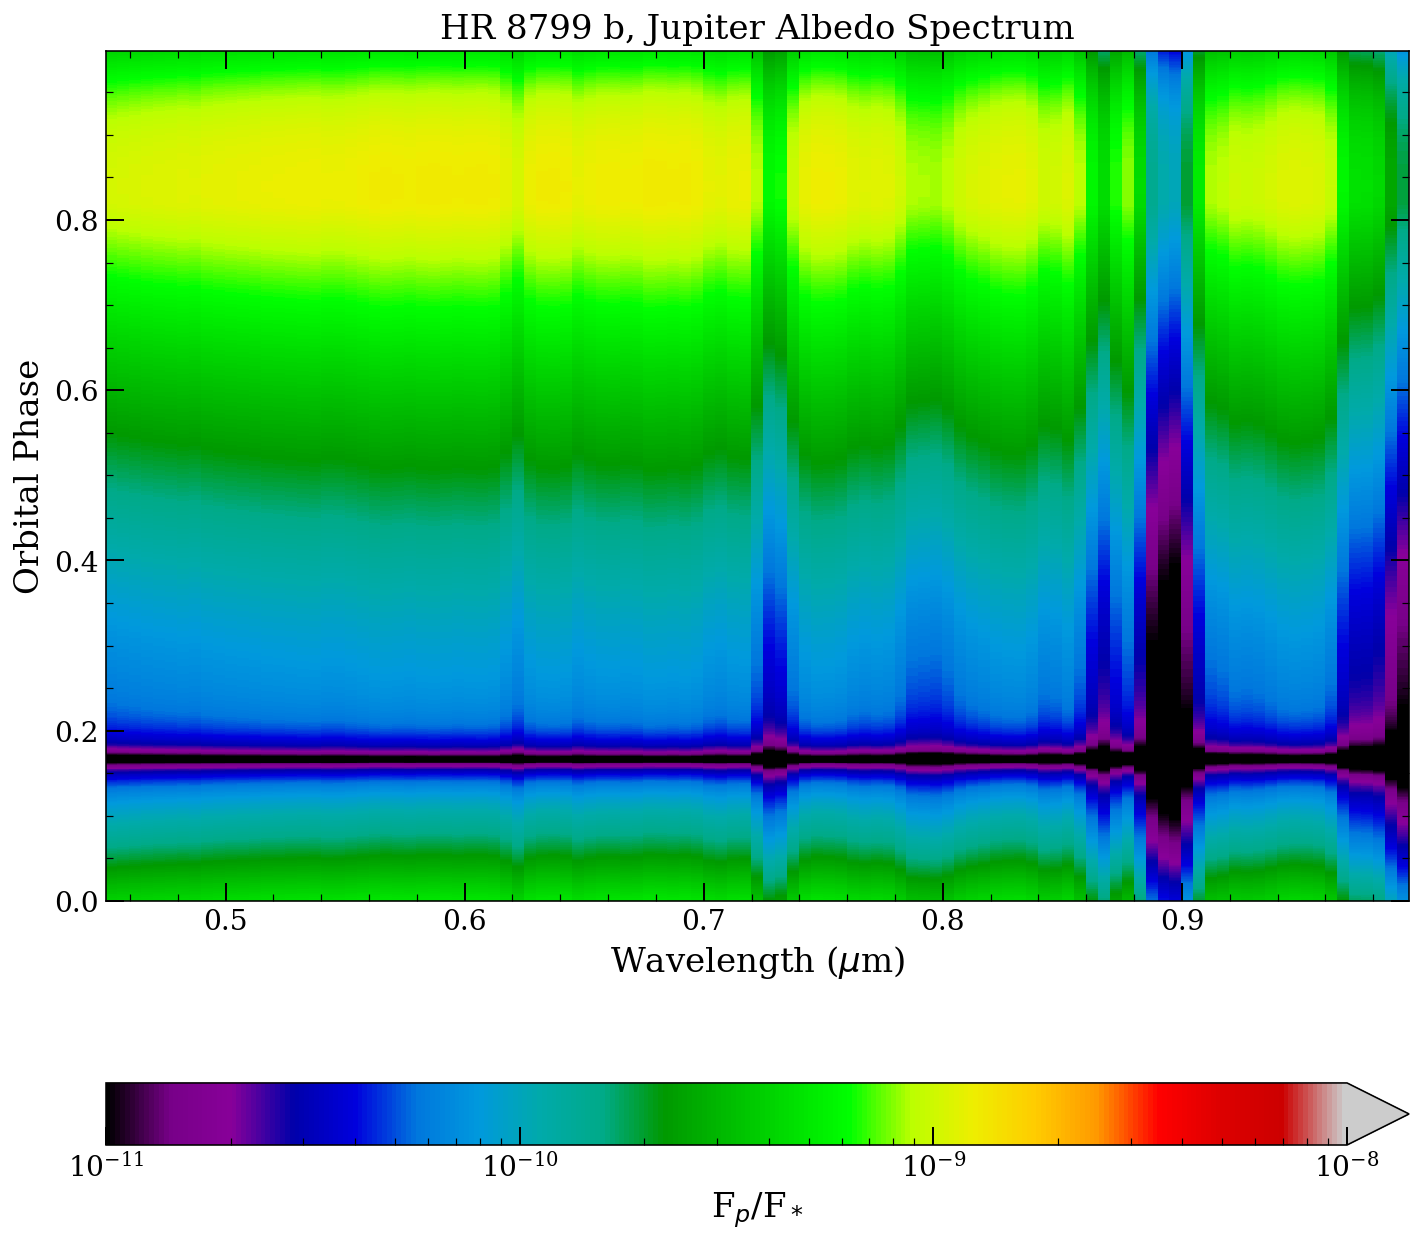

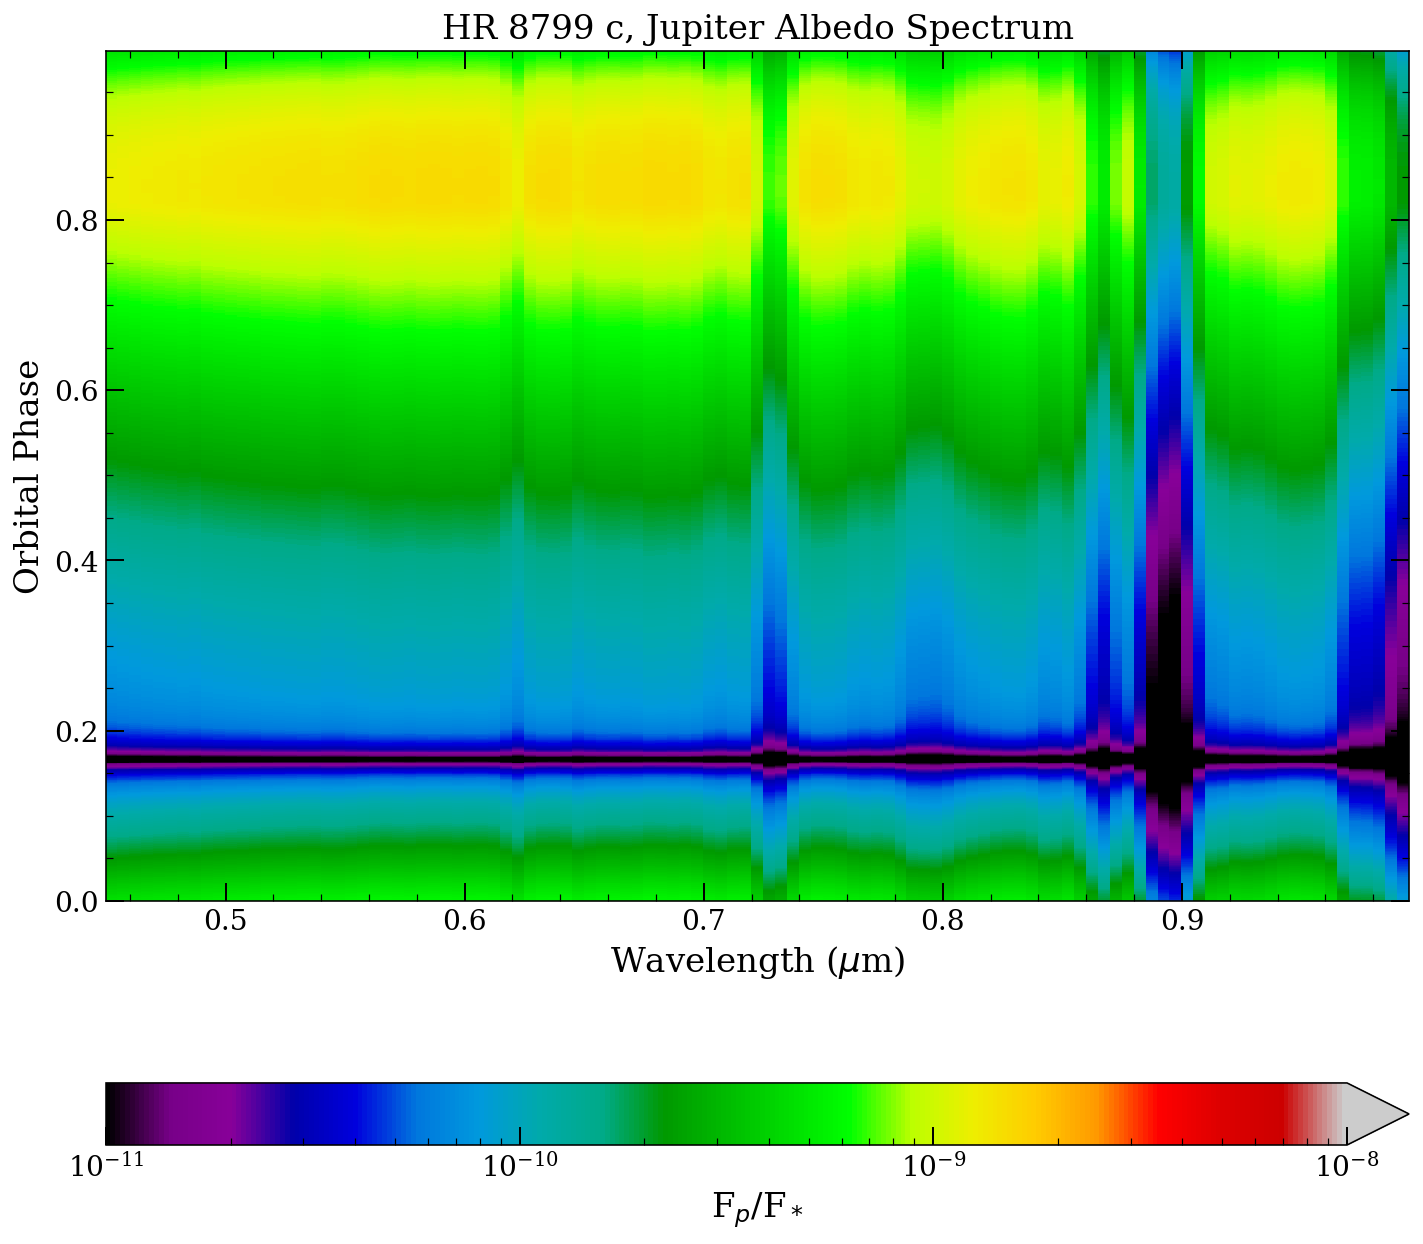

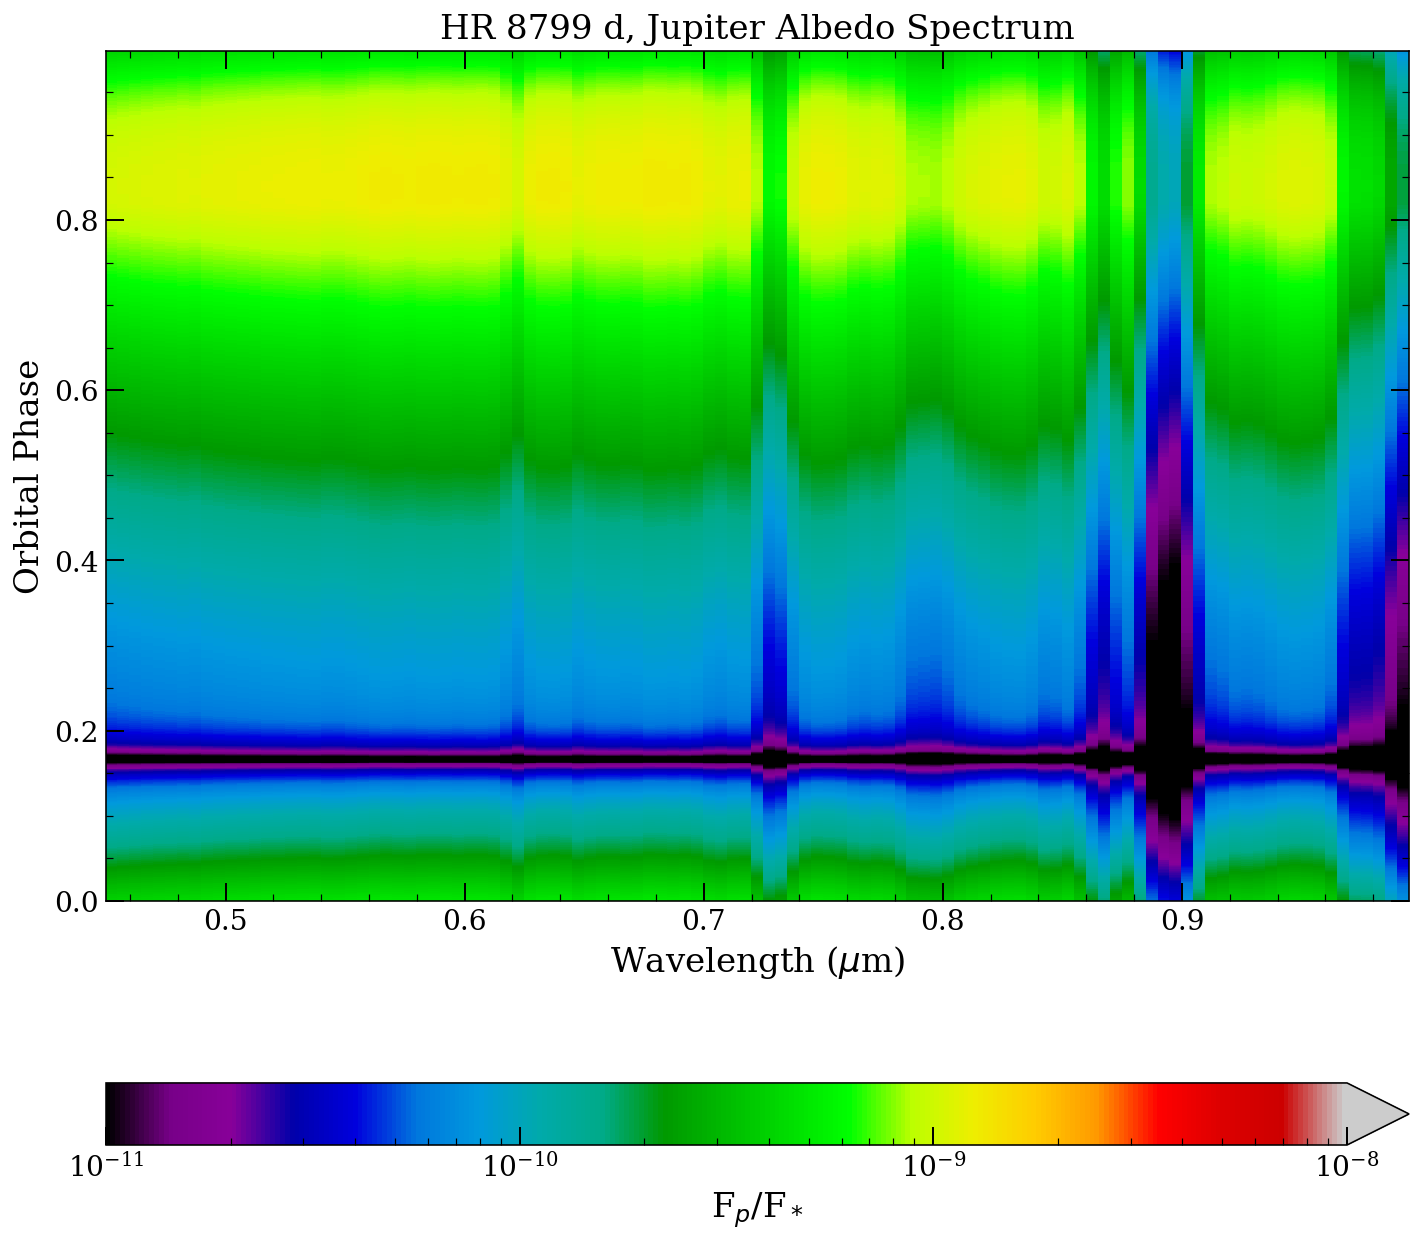

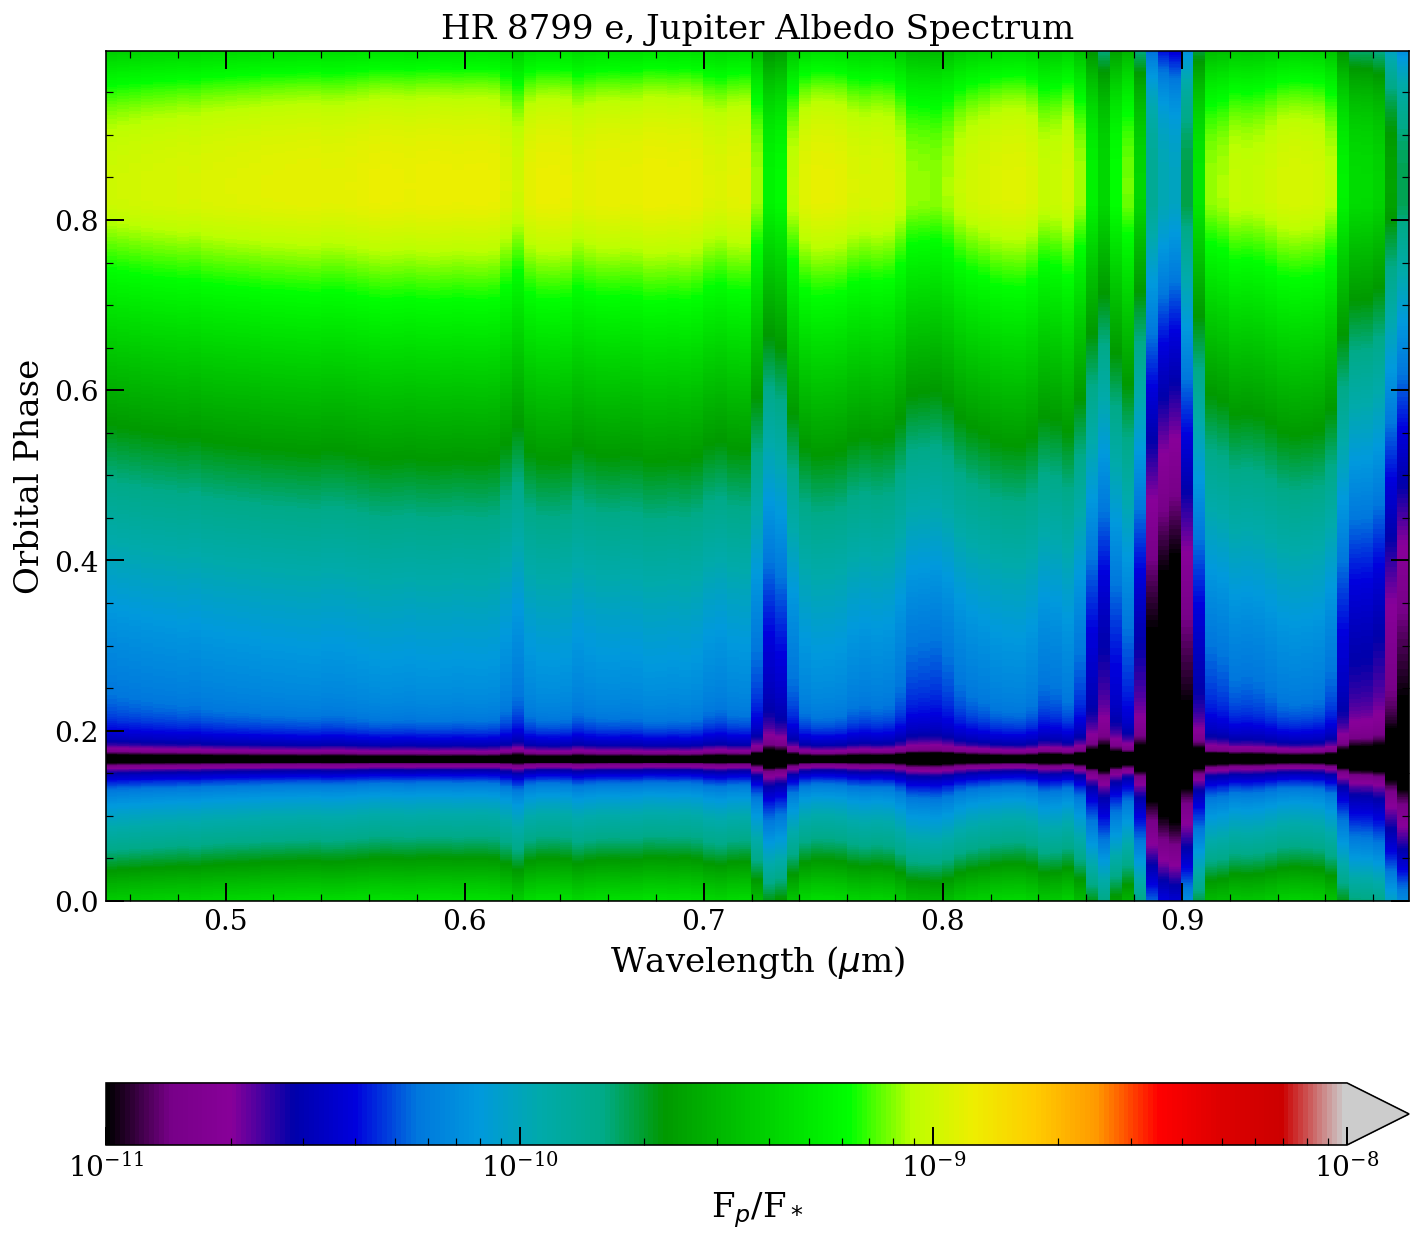

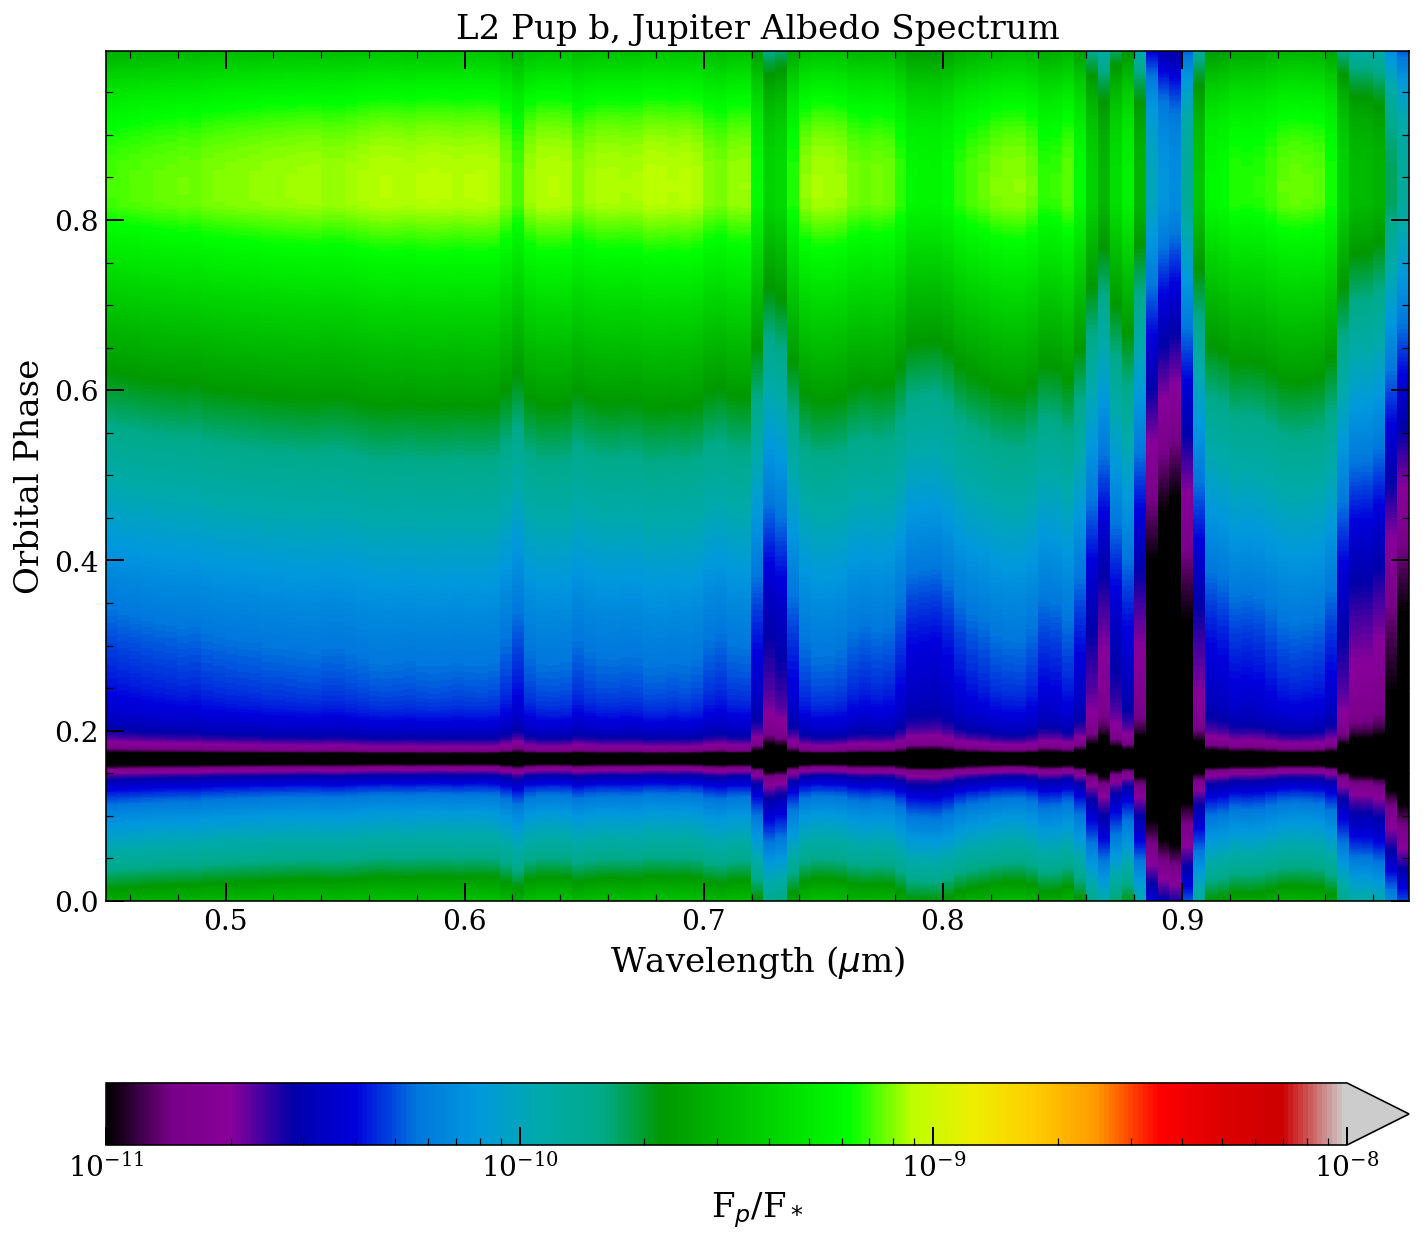

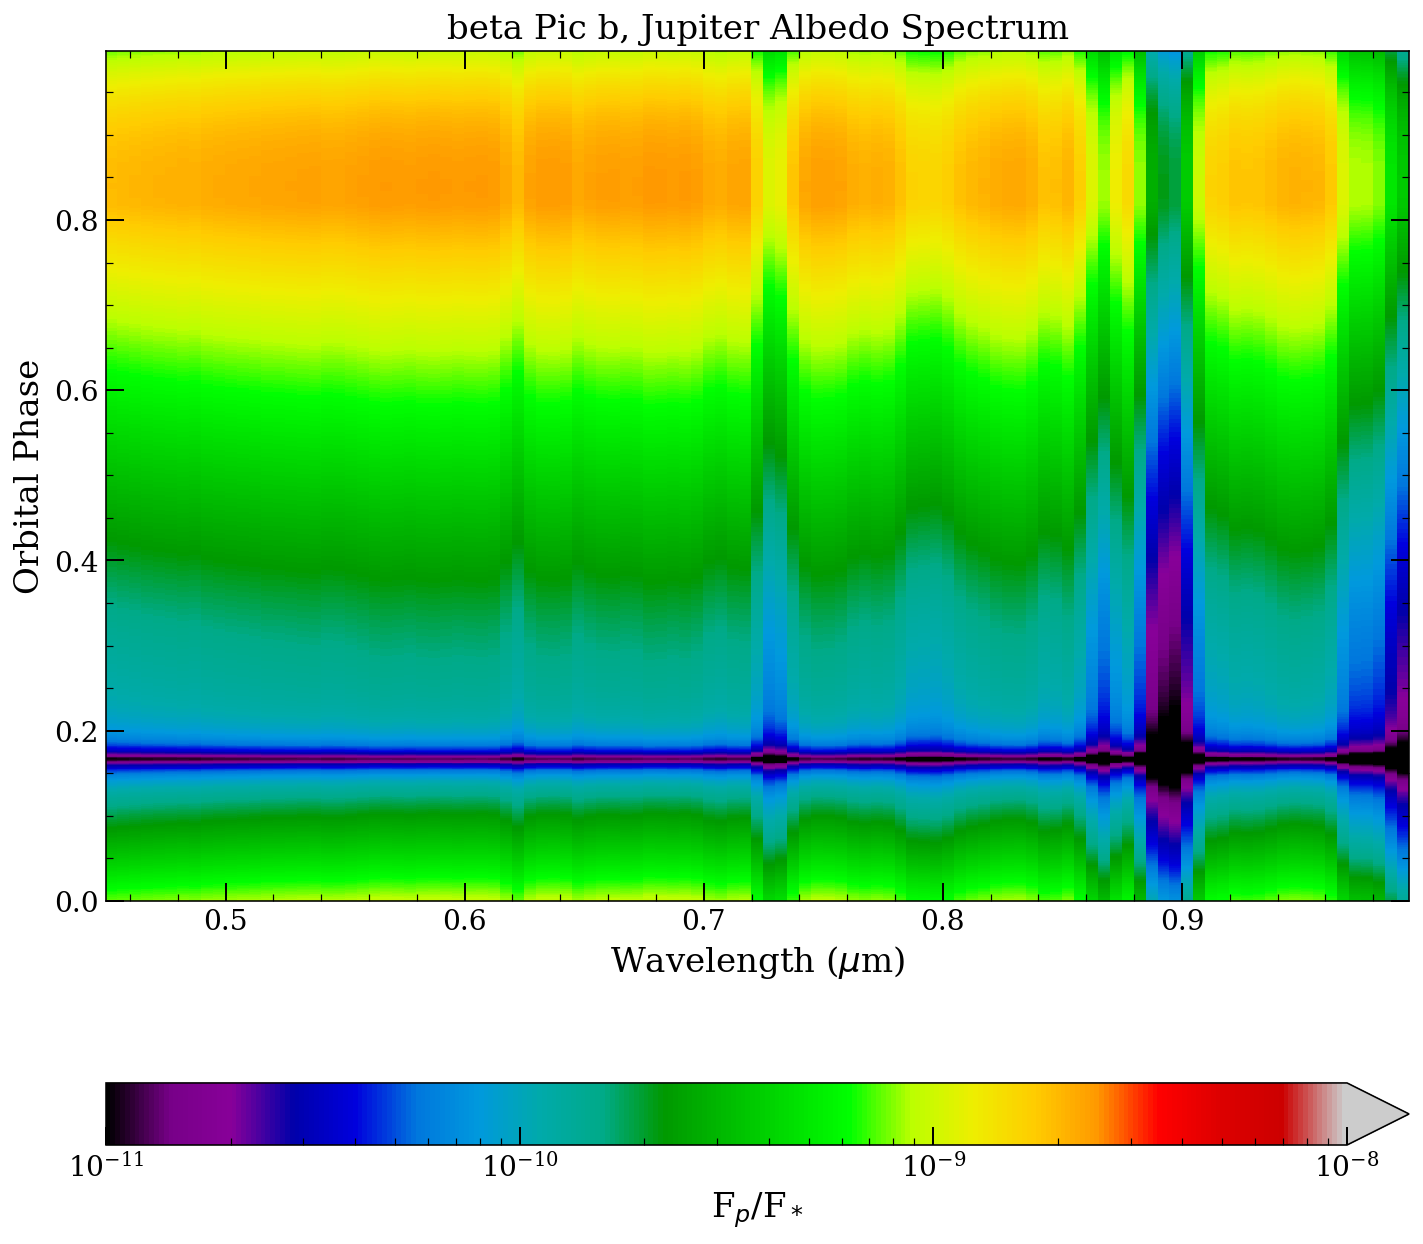

In [5]:
# look at prospects with the IFS
wavelengths = np.arange(0.45,1.0,0.005)
for l in range(len(planet_dictionaries)):
    pdict = planet_dictionaries[l]
    print(pdict['sep'], pdict['phi'], pdict['wa'] )
    plt.figure(figsize=(10.0, 9.0))
    ax=plt.subplot(1,1,1)
    pf.ophase_fpfstar(pdict,orbit,wavelengths,cbar=True)
    ax.set_title('%s, Jupiter Albedo Spectrum'%pdict['pname'],fontsize=17)
    print(pdict['sep'], pdict['phi'], pdict['wa'] )
    plt.tight_layout()
plt.show()

51 Eri b & F0IV & 12.0 & 2.60 & 1.11 & 5.223 & 29.40
beta Pic b & A6V & 11.8 & 12.90 & 1.65 & 3.860 & 19.30
HD 206893 b & F5V & 10.0 & 22.50 & nan & 6.670 & 38.34
HD 984 b & F7V & 18.0 & 48.00 & nan & 7.300 & 47.10
HR 2562 b & F5V & 20.3 & 26.00 & nan & 6.114 & 33.63
HR 8799 d & A5V & 27.0 & 8.30 & 1.20 & 5.960 & 39.40
HR 8799 e & A5V & 16.4 & 9.20 & 1.17 & 5.960 & 39.40
GJ 504 b & GOV & 43.5 & 4.00 & 0.96 & 5.220 & 17.56
GJ 758 b & K0V & 44.8 & 45.00 & nan & 6.360 & 15.50
HD 19467 b & G3V & 51.1 & 52.00 & nan & 7.000 & 30.86
HR 8799 b & A5V & 68.0 & 7.00 & 1.20 & 5.960 & 39.40
HR 8799 c & A5V & 42.9 & 8.30 & 1.30 & 5.960 & 39.40
L2 Pup b & M5 & 2.0 & 12.00 & nan & 5.100 & 64.00
